# Convolutional Neural Network (ANN) _from Scratch_

## Import required libraries

In [1]:
import os
import pickle
import numpy as np
from abc import ABC, abstractmethod

In [2]:
np.random.seed(37)

## Activation Functions

In [3]:
class Activation(ABC):

    @abstractmethod
    def __call__(self, z: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, z: np.ndarray) -> np.ndarray:
        pass

### Linear

In [4]:
class Linear(Activation):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return x

    def derivative(self, z: np.ndarray) -> np.ndarray:
        return np.ones_like(z)

### ReLU

In [5]:
class ReLU(Activation):
    def __call__(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(0, z)

    def derivative(self, z: np.ndarray) -> np.ndarray:
        return (z > 0).astype(float)

### Sigmoid

In [6]:
class Sigmoid(Activation):
    def __call__(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    def derivative(self, z: np.ndarray) -> np.ndarray:
        sigmoid = self(z)
        return sigmoid * (1 - sigmoid)

### Softmax

In [7]:
class Softmax(Activation):
    def __call__(self, z: np.ndarray) -> np.ndarray:
        exps = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def derivative(self, z: np.ndarray) -> np.ndarray:
        z = z.reshape(-1, 1)
        return np.diagflat(z) - np.dot(z, z.T)

### Tanh

In [8]:
class Tanh:
    def __call__(self, z: np.ndarray) -> np.ndarray:
        return np.tanh(z)

    def derivative(self, z: np.ndarray) -> np.ndarray:
        tanh = self(z)
        return 1 - tanh ** 2

## Loss Functions

In [9]:
class Loss(ABC):

    @abstractmethod
    def __call__(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        pass

### Mean Squared Error (MSE)

In [10]:
class MSE(Loss):
    def __call__(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        return np.mean((y_pred - y_true) ** 2) / 2

    def derivative(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        return (y_pred - y_true) / y_true.shape[0]

### Binary Cross Entropy Loss

In [11]:
class BinaryCrossEntropy(Loss):
    def __call__(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)  # avoid log(0)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def derivative(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)  # Prevent div by 0
        return (y_pred - y_true) / (y_pred * (1 - y_pred) * y_true.shape[0])

## Cross Entropy Loss (Sparse Categorical)
_basically one hot encoded_

In [12]:
class SparseCategoricalCrossEntropy(Loss):
    def __call__(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)  # prevent log(0)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    def derivative(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        return (y_pred - y_true) / y_true.shape[0]

## Layer

In [13]:
class Layer(ABC):

    @abstractmethod
    def __init__(self, in_dim: int, out_dim: int):
        pass

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def backward(self, dA: np.ndarray, lr: float) -> np.ndarray:
        pass

### Dense Layer

In [14]:
class Dense(Layer):
    def __init__(self, in_dim: int, out_dim: int, activation: Activation):
        self.weights = np.random.random((in_dim, out_dim)) * np.sqrt(1 / in_dim)
        self.bias = np.zeros((1, out_dim))
        self.activation = activation
        self.x = None
        self.z = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        self.z = self.x @ self.weights + self.bias
        return self.activation(self.z)

    def backward(self, dA: np.ndarray, lr: np.ndarray) -> np.ndarray:
        if isinstance(self.activation, Softmax):
            dz = dA
        else:
            dz = dA * self.activation.derivative(self.z)
        dw = self.x.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)

        # prevent exploding gradients
        np.clip(dw, -1, 1, out=dw)
        np.clip(db, -1, 1, out=db)

        self.weights -= lr * dw
        self.bias -= lr * db
        return dz @ self.weights.T

    @property
    def params_(self):
        return (self.weights, self.bias)

### Convolutional Layer

In [16]:
class Conv2D(Layer):
    def __init__(self, in_channels: int, num_filters: int, kernel_size: int | tuple[int], stride: int | tuple[int], padding: int | str = "valid"):
        self.in_channels = in_channels    # no. of images
        self.num_filters = num_filters    # no. of kernels

        # Each a tuple of dim: (W, H)
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, )*2

        if padding == "same":     # maintains output size same as input size
            self.padding = kernel_size // 2
        elif padding == "valid":  # 0 padding
            self.padding = 0
        else:   # integer padding
            self.padding = int(padding)

        self.kh, self.kw = self.kernel_size

        # setting limit to prevent exploding gradients
        limit = np.sqrt(1 / (self.in_channels * self.kh * self.kw))
        self.kernels = np.random.uniform(-limit, limit, (num_filters, in_channels, self.kh, self.kw))
        self.bias = np.zeros((num_filters, 1))


    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        # N: # images, c_in: channels (RGB), H: Height, W: Width
        self.N, self.c_in, self.H, self.W = x.shape

        H_out = ((self.H - self.kh + (2 * self.padding)) // self.stride[1]) + 1
        W_out = ((self.W - self.kw + (2 * self.padding)) // self.stride[0]) + 1

        self.padded_area = np.pad(x, (
            (0, 0),   # N images - No Padding
            (0, 0),   # channels (RGB) - No Padding
            (self.padding, self.padding),   # Height
            (self.padding, self.padding)    # Width
        ))

        output_matrix = np.zeroes((N, self.num_filters, H_out, W_out))

        for image in range(self.N):  # each image
            for filter_ in range(self.num_filters):   # each filter
                for h in range(H_out):      # height
                    for w in range(W_out):  # width
                        h_start = h * self.stride[1]
                        w_start = w * self.stride[0]
                        h_end = h_start + self.kh
                        w_end = w_start + self.kw

                        window = self.padded_area[image, :, h_start:h_end, w_start:w_end]
                        output_matrix[image, filter_, h, w] = np.sum(window * self.kernels[filter_])
                        output_matrix += self.bias

        return output_matrix

    def backward(self, dA: np.ndarray, lr: int):
        # making matrices to store derivatives
        d_padded = np.zeros_like(self.padded_area)
        dk = np.zeros_like(self.kernels)
        db = np.zeros_like(self.bias)

        # Dimensions
        dH, dW = d_padded.shape[2:]

        for image in range(self.N):  # each image
            for filter_ in range(self.num_filters):   # each filter
                for h in range(dH):      # height
                    for w in range(dW):  # width
                        h_start = h * self.stride[1]
                        w_start = w * self.stride[0]
                        h_end = h_start + self.kh
                        w_end = w_start + self.kw

                        window = self.padded_area[image, :, h_start:h_end, w_start:w_end]
                        dk[filter_] += dA[image, filter_, h, w] * window
                        db[filter_] += dA[image, filter_, h, w]

                        d_padded[image, :, h_start:h_end, w_start:w_end] = dA[image, filter_, h, w] * self.kernels[filter_]

        # Remove padding from dx
        if self.padding != 0:
            dx = d_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dx = d_padded

        # update weights (kernels) & bias
        self.weights -= lr * dk
        self.bias -= lr * db

        return dx

    @property
    def params_(self):
        return (self.weights, self.bias)


### Pooling Layers

In [17]:
class Pooling(Layer):
    def __init__(self,  kernel_size: int | tuple[int], stride: int | tuple[int], padding: int | str = "valid"):
        # Each a tuple of dim: (W, H)
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, )*2

        if padding == "same":     # maintains output size same as input size
            self.padding = kernel_size // 2
        elif padding == "valid":  # 0 padding
            self.padding = 0
        else:   # integer padding
            self.padding = int(padding)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.padded_area = np.pad(x, (
                (0, 0),    # N images - no padding
                (0, 0),    # channels (RBG) - no padding
                (self.padding, self.padding),   # Height
                (self.padding, self.padding)    # Width
        ))

        N, C, H, W = self.padded_area.shape
        H_out = 1 + (H - self.kernel_size[1]) // self.stride[1]
        W_out = 1 + (W - self.kernel_size[0]) // self.stride[0]
        output_matrix = np.zeros((N, C, H_out, W_out))

        for h in range(H_out):
            for w in range(W_out):
                h_start = h * self.stride[1]
                h_end = h_start + self.kernel_size[1]
                w_start = w * self.stride[0]
                w_end = w_start + self.kernel_size[0]

                window = self.padded_area[:, :, h_start:h_end, w_start:w_end]
                output_matrix[:, :, i, j] = self.__pool_op(window, h, w)

        return output_matrix

    def backward(self, dA: np.ndarray, lr: None) -> np.ndarray:
        d_padded = np.zeros_like(self.padded_area)
        dH, dW = d_padded.shape[2:]

        for h in range(dH):
            for w in range(dW):
                h_start = h * self.stride[1]
                h_end = h_start + self.kernel_size[1]
                w_start = w * self.stride[0]
                h_end = w_start + self.kernel_size[0]

                window = self.padded_area[:, :, h_start:h_end, w_start:w_end]
                d_window = self._backward_mask(window, dA[:, :, h, w], h, w)
                d_padded[:, :, h_start:h_end, w_start:w_end] += d_window

        # Remove padding from dx
        if self.padding != 0:
            dx = d_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dx = d_padded

        return dx

    def _pool_op(self, window, h, w):
        ...

    def _backward_mask(self, window, h, w):
        ...


#### Max Pooling

In [18]:
class MaxPool2D(Pooling):
    def _pool_op(self, window, h, w):
        pooled = np.max(window, axis=(2, 3)) # only calculate max of Height & Width
        # storing indices of max elements for backward
        self.max_mask = np.equal(
            window,
            pooled[:, :, None, None]
        )
        return pooled

    def _backward_mask(self, window, dA_sliced, h, w):
        d_window = self.max_mask * dA_sliced[:, :, None, None]
        return d_window

#### Min Pooling

In [19]:
class MinPool2D(Pooling):
    def _pool_op(self, window, h, w):
        pooled = np.min(window, axis=(2, 3)) # only height & width
        # storing min indices of min elements for backward
        self.min_mask = np.equal(
            window,
            pooled[:, :, None, None]
        )
        return pooled

    def _backward_mask(self, window, dA_sliced, h, w):
        d_window = self.min_mask * dA_sliced[:, :, None, None]
        return d_window

#### Avg Pooling

In [20]:
class AvgPool2D(Pooling):
    def _pool_op(self, window, h, w):
        pooled = np.mean(window, axis=(2, 3)) # only height & width
        return pooled

    def _backward_mask(self, window, dA_sliced, h, w):
        N, C, kh, kw = window.shape
        avg_grad = dA_sliced[:, :, None, None] / (kh * kw)
        return np.ones_like(window) * avg_grad

## Neural Network

In [15]:
class NeuralNetwork:
    def __init__(self, layers: list[Layer], loss: Loss):
        self.layers = layers
        self.loss_fn = loss

    def add(self, layer: Layer):
        self.layers.append(layer)

    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y_pred: np.ndarray, y_true: np.ndarray, lr: float):
        dA = self.loss_fn.derivative(y_pred, y_true)
        for layer in reversed(self.layers):
            dA = layer.backward(dA, lr)

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        val_X: np.ndarray = None,
        val_y: np.ndarray = None,
        n_iters: int = 100,
        lr: float = 0.01,
        verbose: bool = True
    ):
        self.history = []
        epoch_10pct = 1 if n_iters < 10 else int(n_iters * 0.1)

        for epoch in range(1, n_iters + 1):
            y_pred = self.forward(X)
            train_loss = self.loss_fn(y_pred, y)
            self.backward(y_pred, y, lr)

            if val_X is not None and val_y is not None:
                y_val_pred = self.forward(val_X)
                val_loss = self.loss_fn(y_val_pred, val_y)

            self.history.append(train_loss if val_X is None else (train_loss, val_loss))

            if verbose and epoch % epoch_10pct == 0:
                l = len(str(n_iters))
                print(
                    f"Epoch {epoch:{len(str(n_iters))}d} | Train Loss: {train_loss:.4f}" +
                    ("" if val_X is None else f" | Val Loss: {val_loss:.4f}")
                     )
        return self.history

    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

    @property
    def params_(self) -> np.ndarray:
        return [layer.params_ for layer in self.layers]

    def summary(self):
        print("Model Summary:")
        print("-" * 60)
        total_params = 0

        for i, layer in enumerate(self.layers, start=1):
            name = layer.__class__.__name__
            w_shape = layer.weights.shape
            b_shape = layer.bias.shape
            num_params = np.prod(w_shape) + np.prod(b_shape)
            total_params += num_params
            print(f"{name} layer {i}: Params: {num_params}"
                  f" ({w_shape[0]} x {w_shape[1]} + {b_shape[1]})")

        print("-" * 60)
        print(f"Total Layers: {i}")
        print(f"Total Trainable Parameters: {total_params}")
        print("-" * 60)

    def save(self, filepath: str):
        with open(filepath, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filepath: str) -> "NeuralNetwork":
        with open(filepath, "rb") as f:
            return pickle.load(f)


## Saving model

In [52]:
MODEL_BASE_PATH = "../Models/Custom_CNN/"
os.makedirs(MODEL_BASE_PATH, exist_ok=True)

conv1: torch.Size([1, 64, 112, 112])


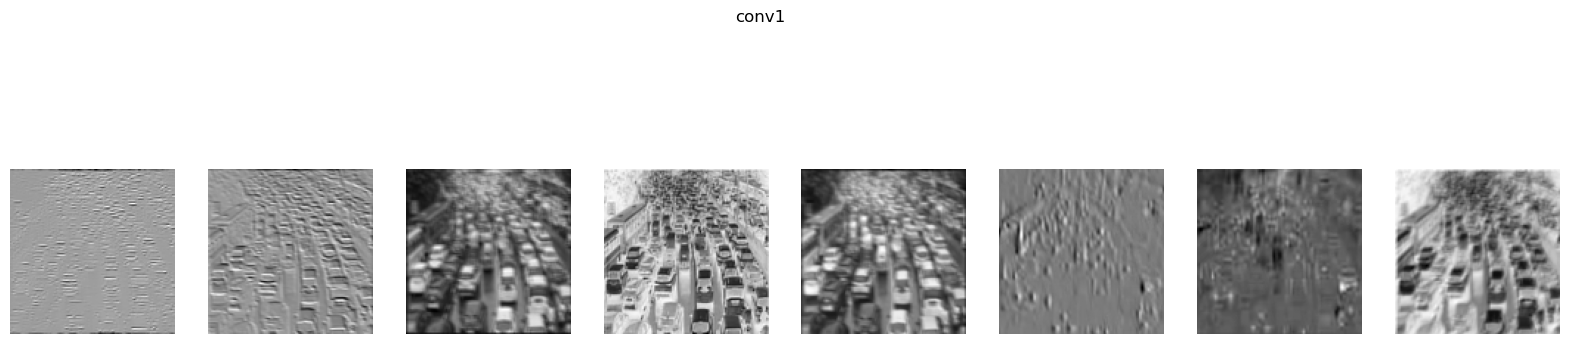

bn1: torch.Size([1, 64, 112, 112])


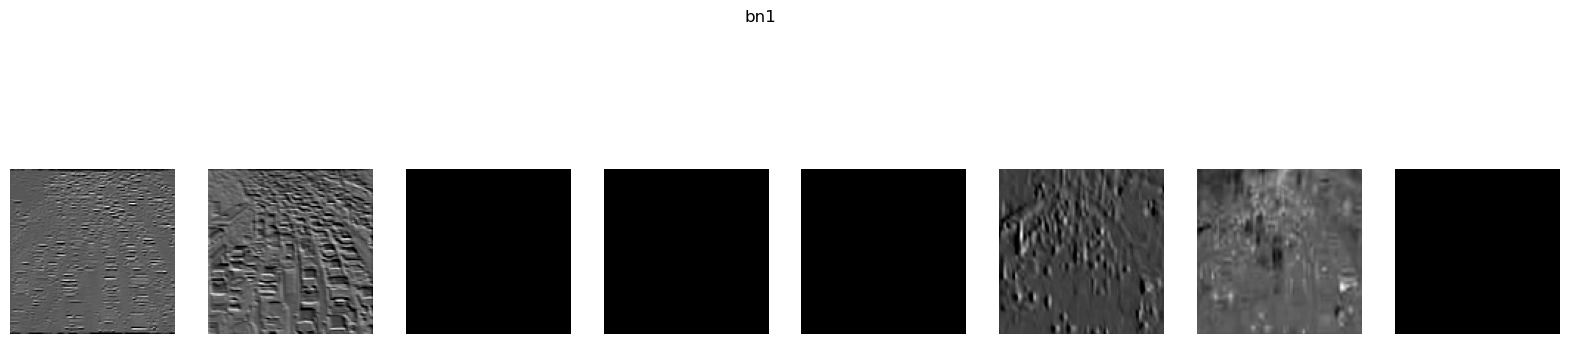

relu: torch.Size([1, 64, 112, 112])


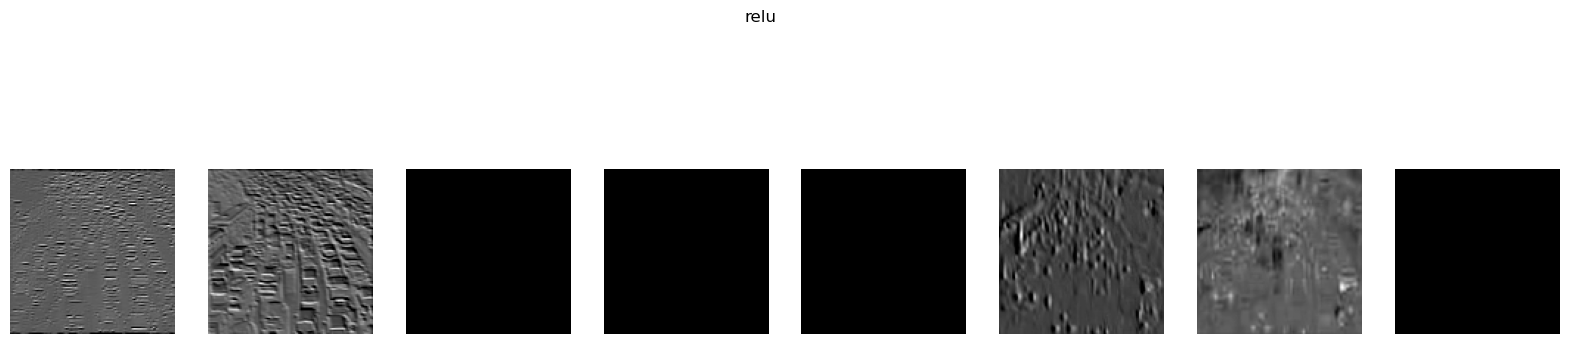

maxpool: torch.Size([1, 64, 56, 56])


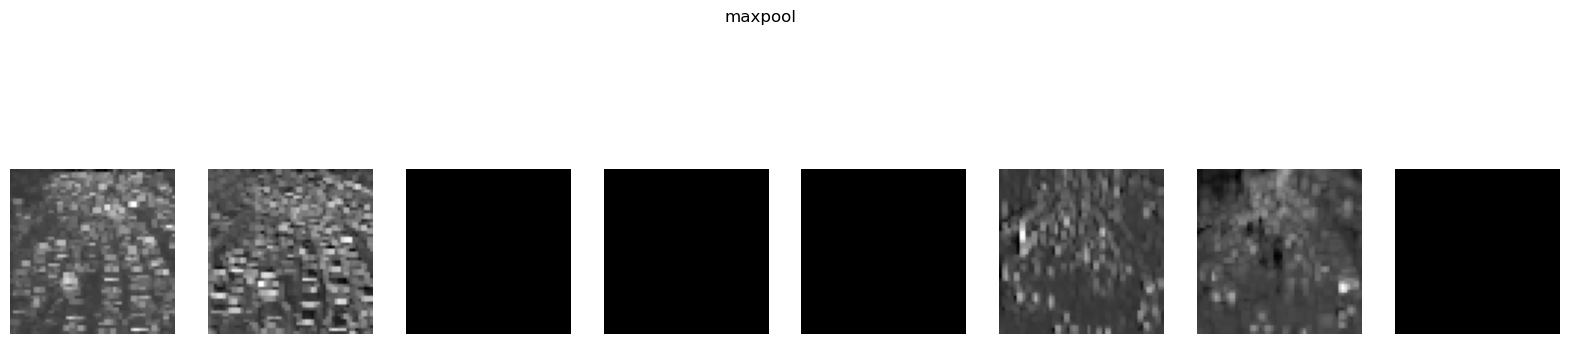

layer1.0.conv1: torch.Size([1, 64, 56, 56])


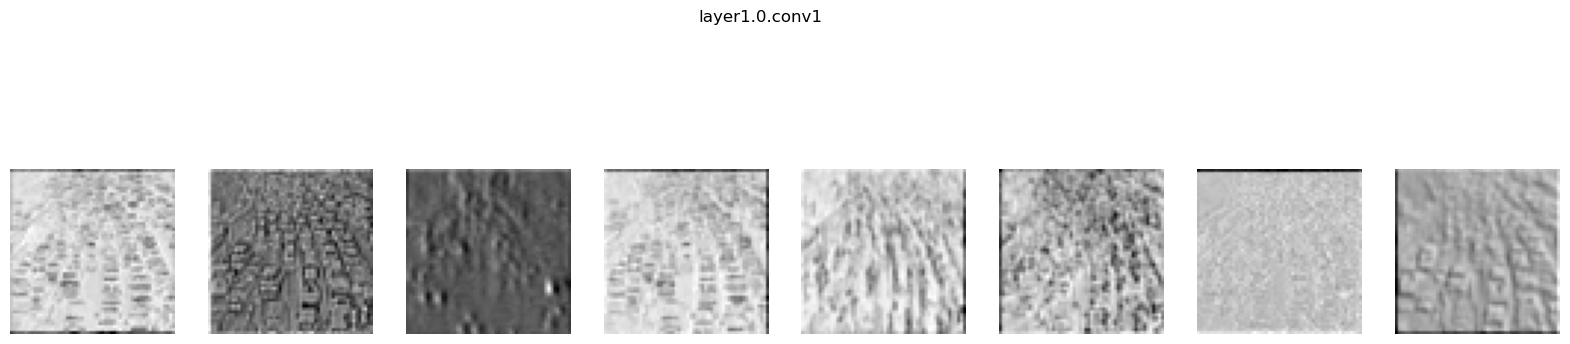

layer1.0.bn1: torch.Size([1, 64, 56, 56])


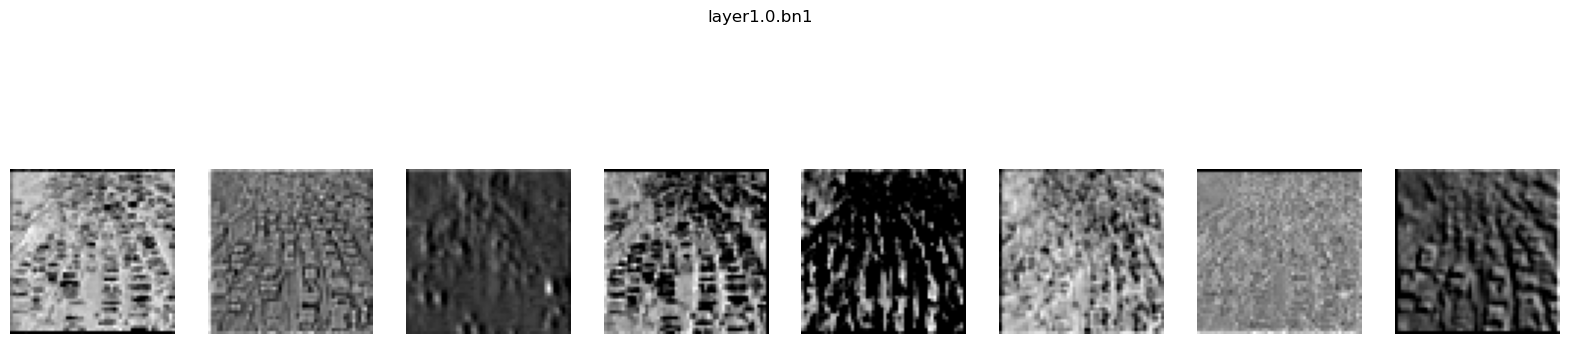

layer1.0.relu: torch.Size([1, 64, 56, 56])


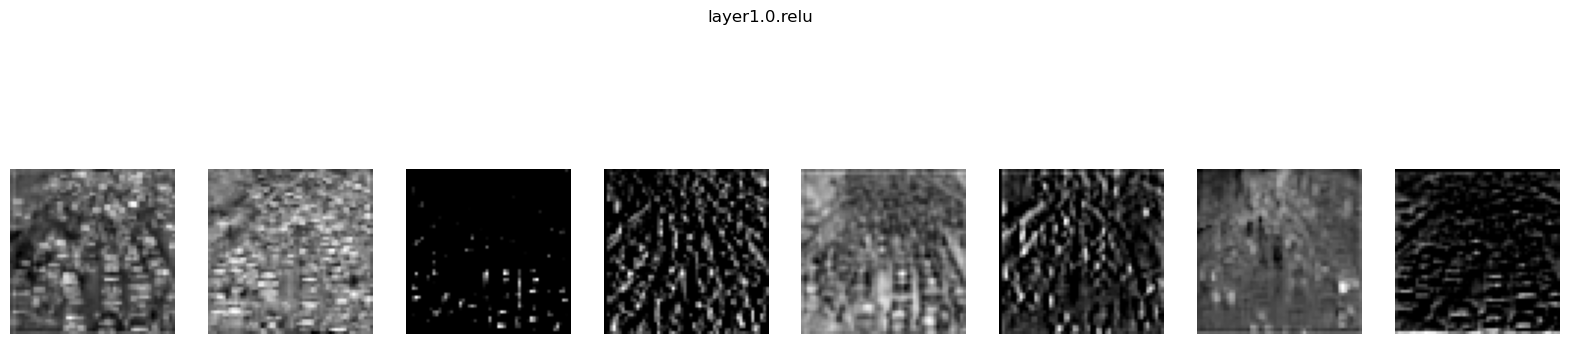

layer1.0.conv2: torch.Size([1, 64, 56, 56])


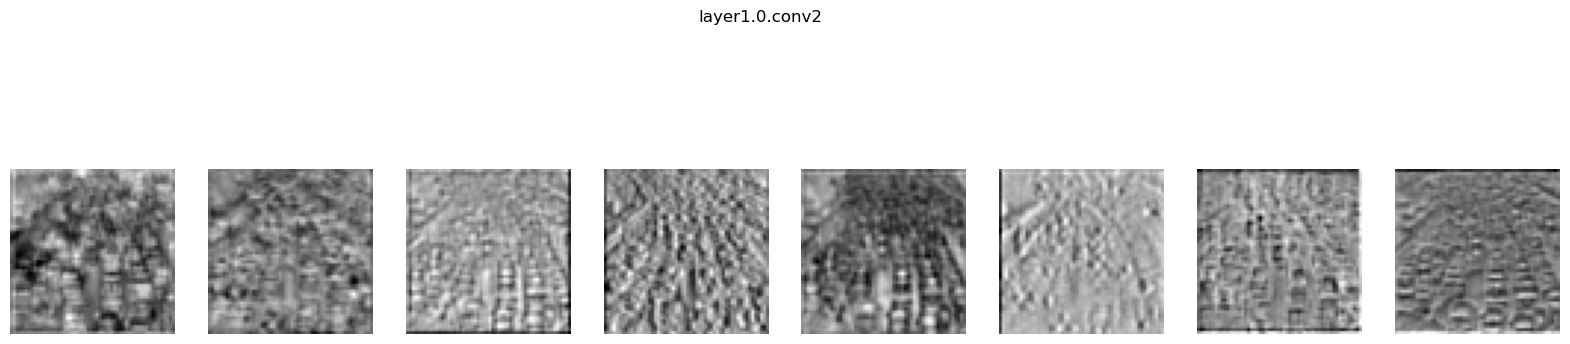

layer1.0.bn2: torch.Size([1, 64, 56, 56])


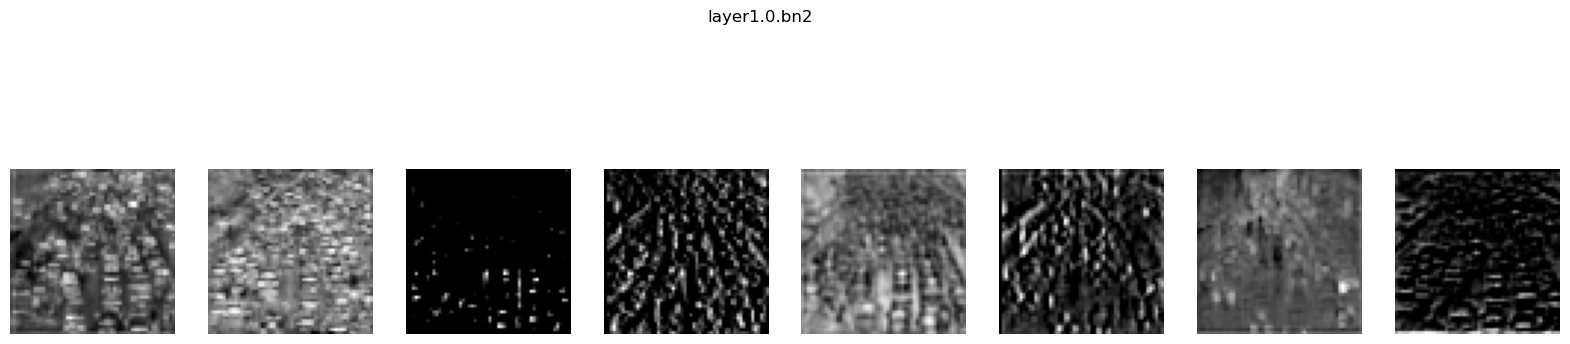

layer1.0: torch.Size([1, 64, 56, 56])


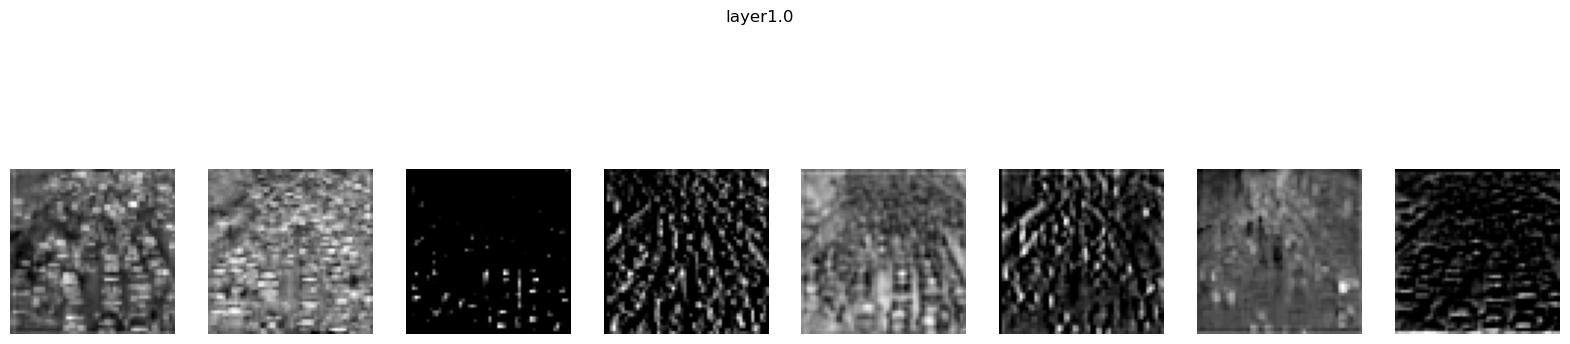

layer1.1.conv1: torch.Size([1, 64, 56, 56])


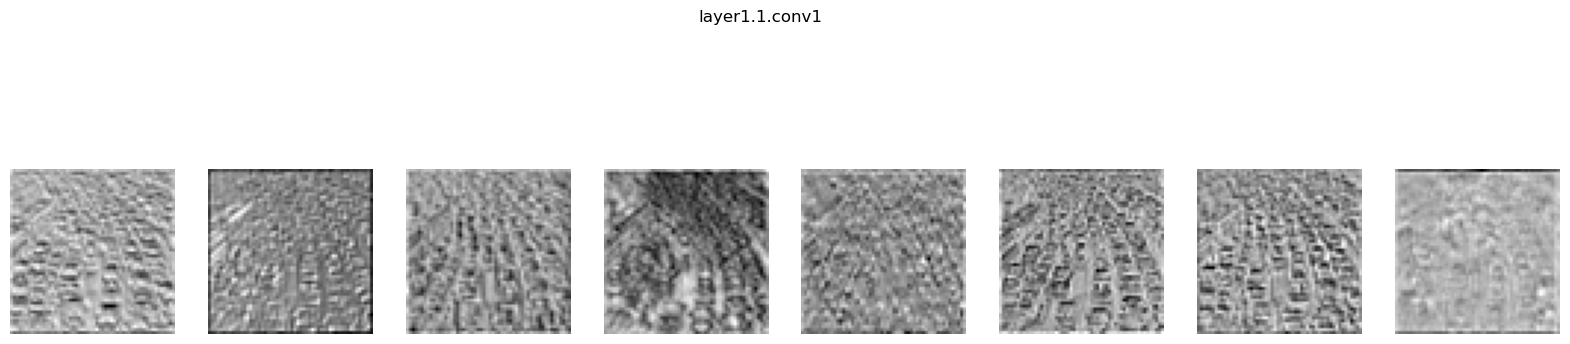

layer1.1.bn1: torch.Size([1, 64, 56, 56])


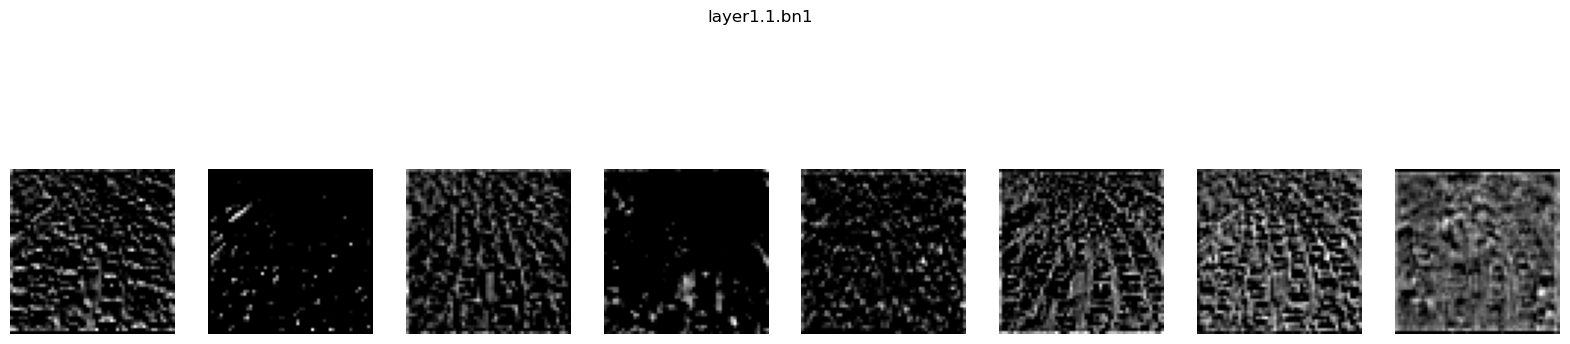

layer1.1.relu: torch.Size([1, 64, 56, 56])


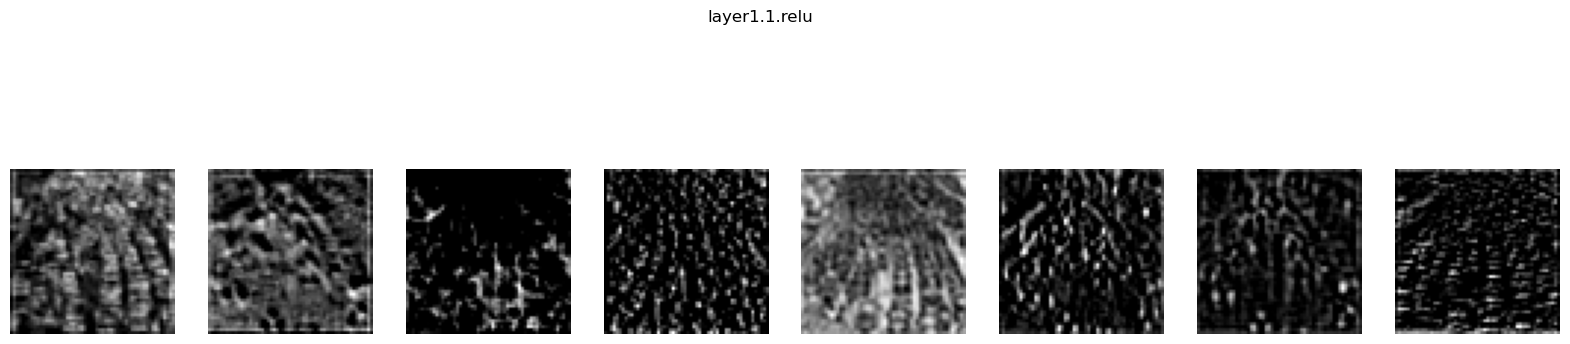

layer1.1.conv2: torch.Size([1, 64, 56, 56])


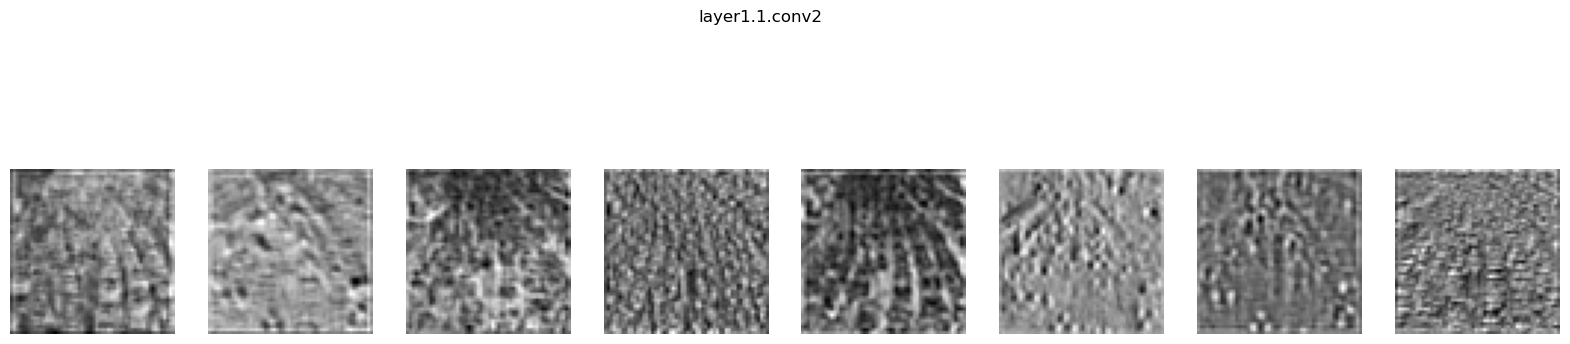

layer1.1.bn2: torch.Size([1, 64, 56, 56])


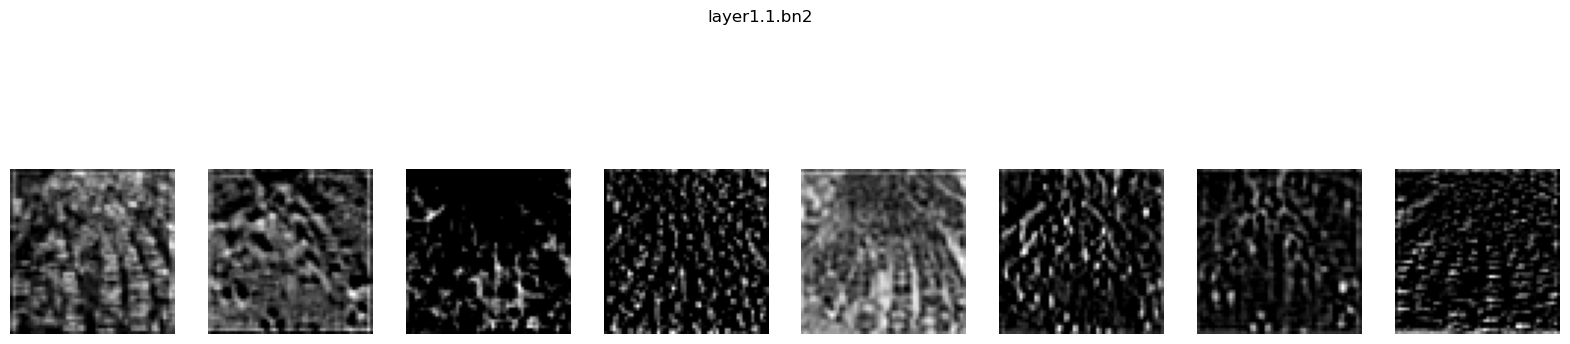

layer1.1: torch.Size([1, 64, 56, 56])


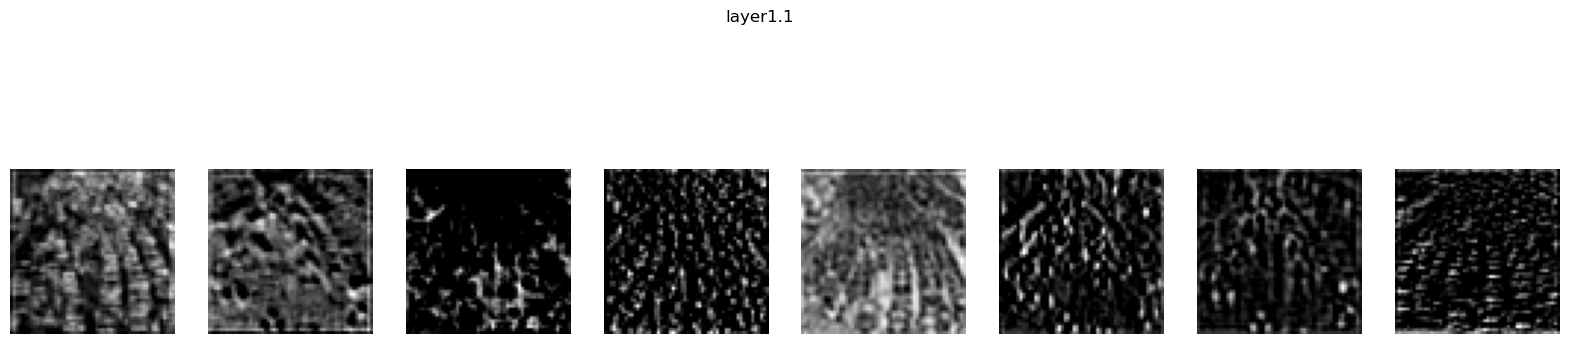

layer1: torch.Size([1, 64, 56, 56])


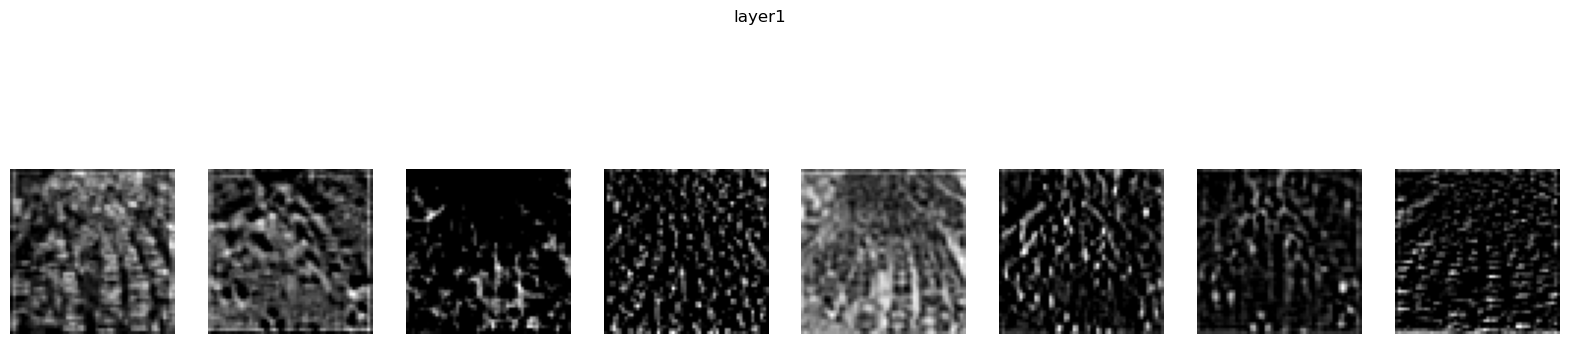

layer2.0.conv1: torch.Size([1, 128, 28, 28])


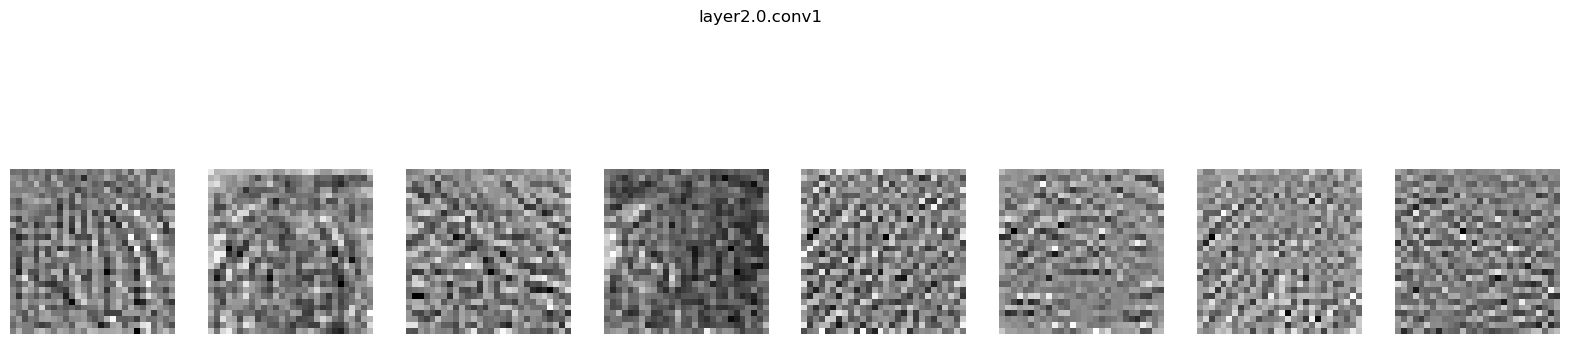

layer2.0.bn1: torch.Size([1, 128, 28, 28])


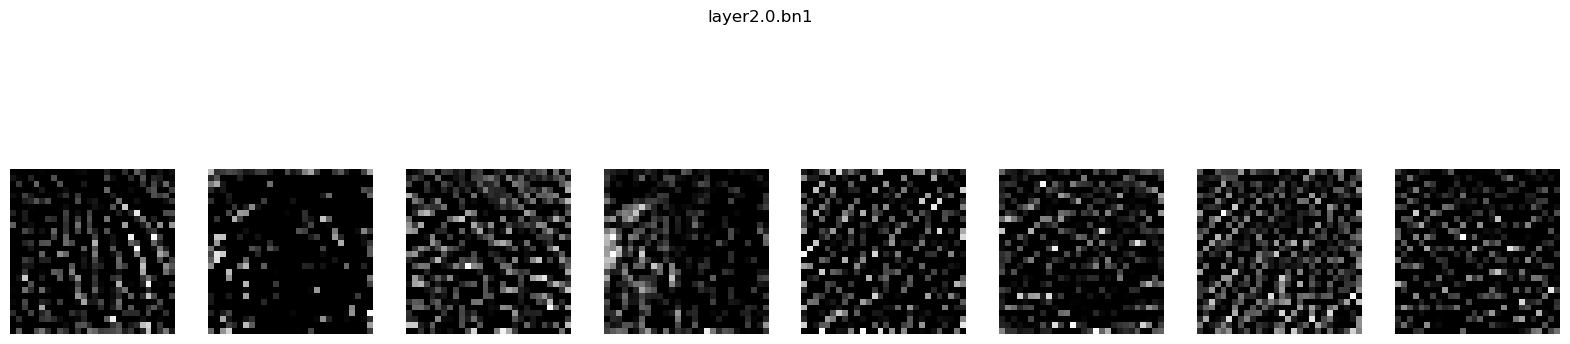

layer2.0.relu: torch.Size([1, 128, 28, 28])


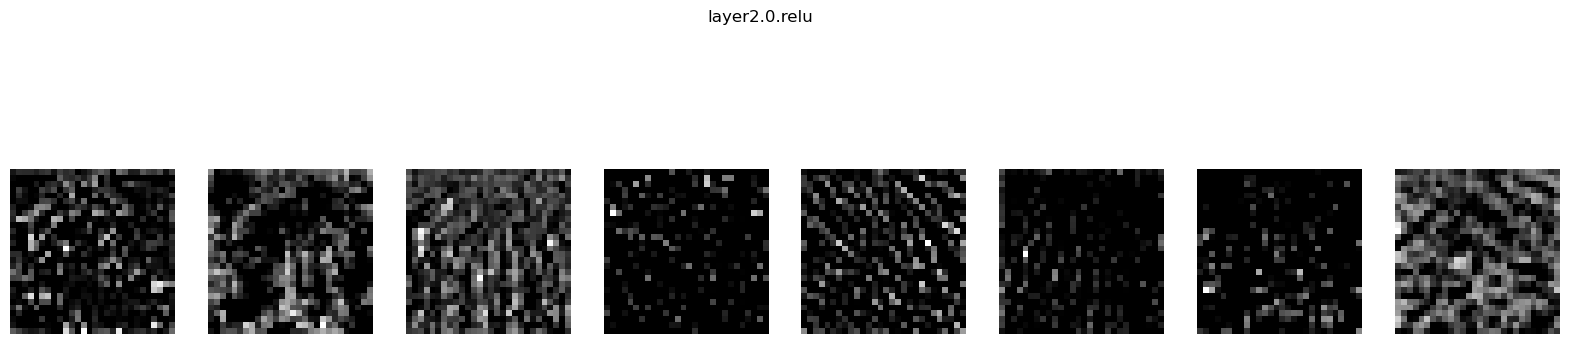

layer2.0.conv2: torch.Size([1, 128, 28, 28])


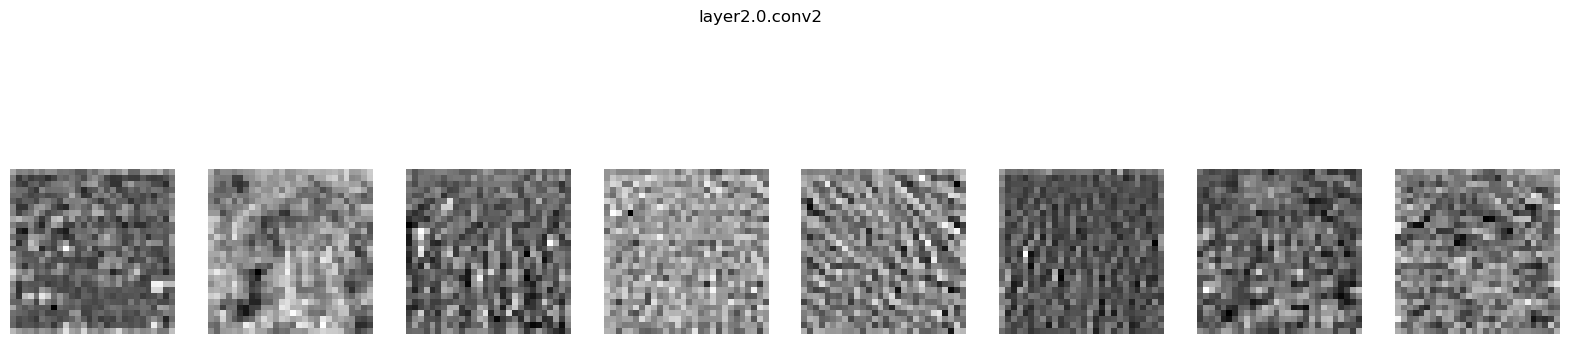

layer2.0.bn2: torch.Size([1, 128, 28, 28])


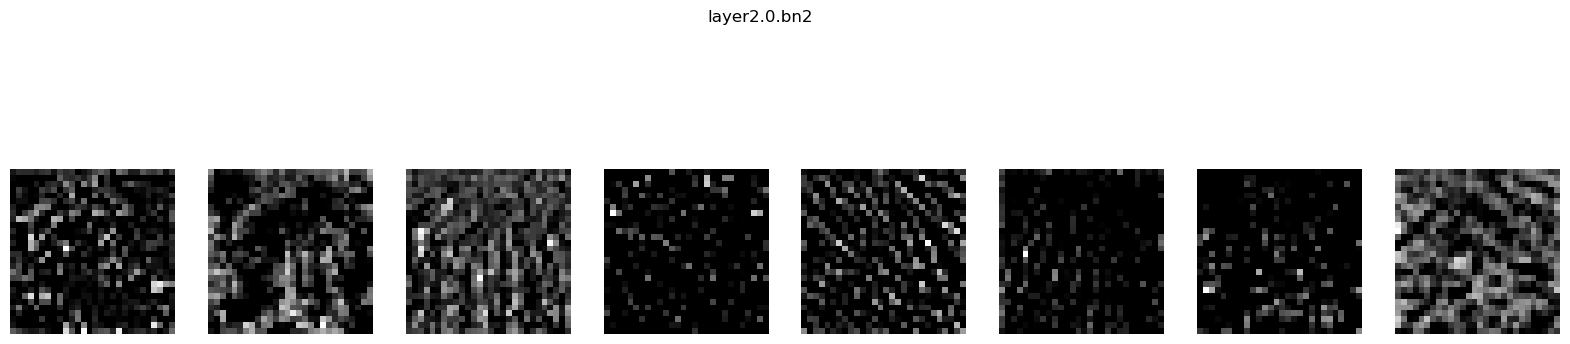

layer2.0.downsample.0: torch.Size([1, 128, 28, 28])


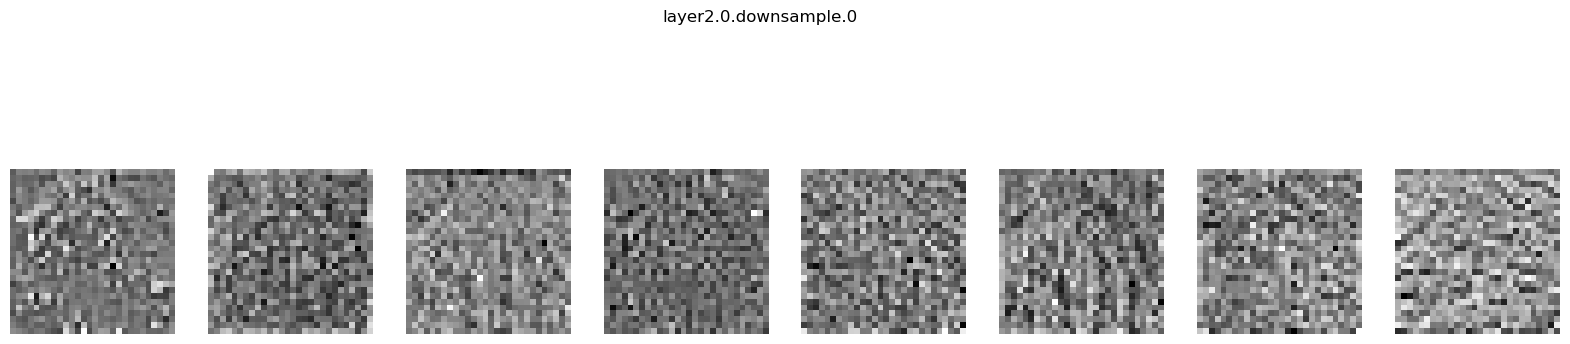

layer2.0.downsample.1: torch.Size([1, 128, 28, 28])


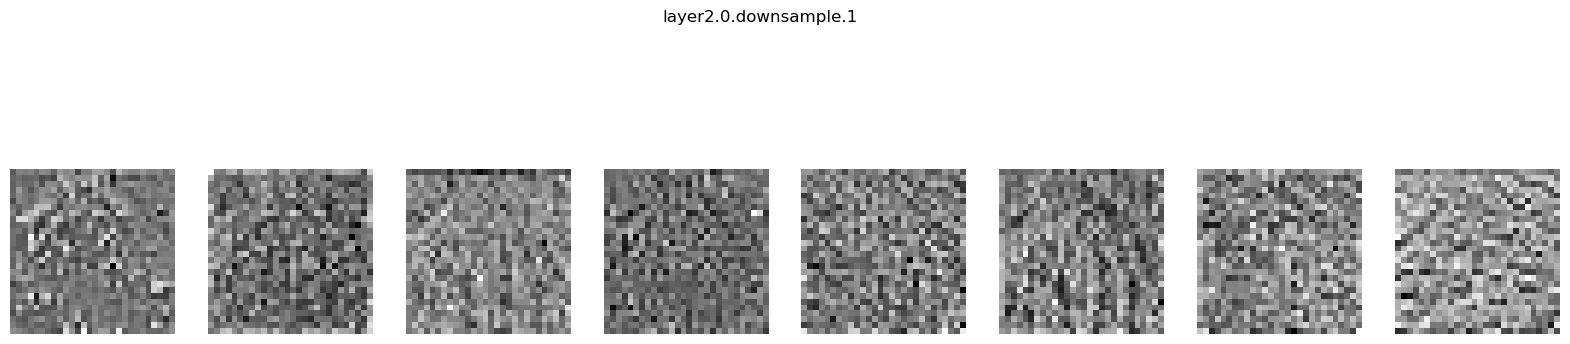

layer2.0.downsample: torch.Size([1, 128, 28, 28])


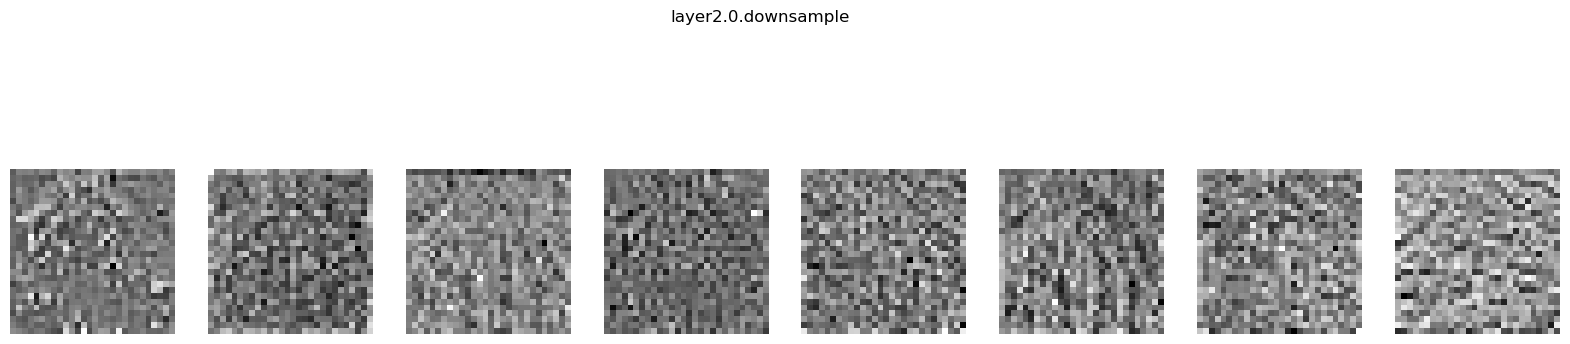

layer2.0: torch.Size([1, 128, 28, 28])


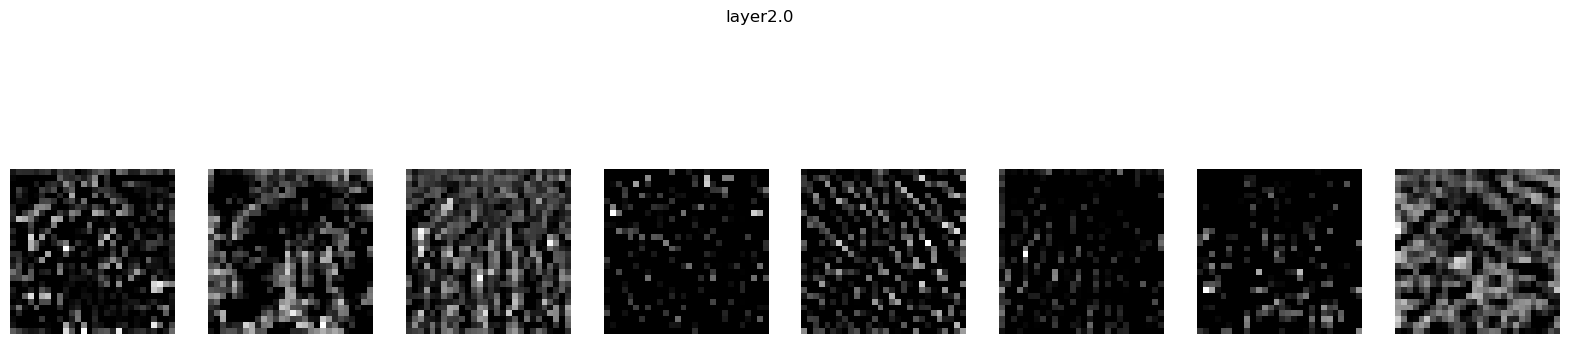

layer2.1.conv1: torch.Size([1, 128, 28, 28])


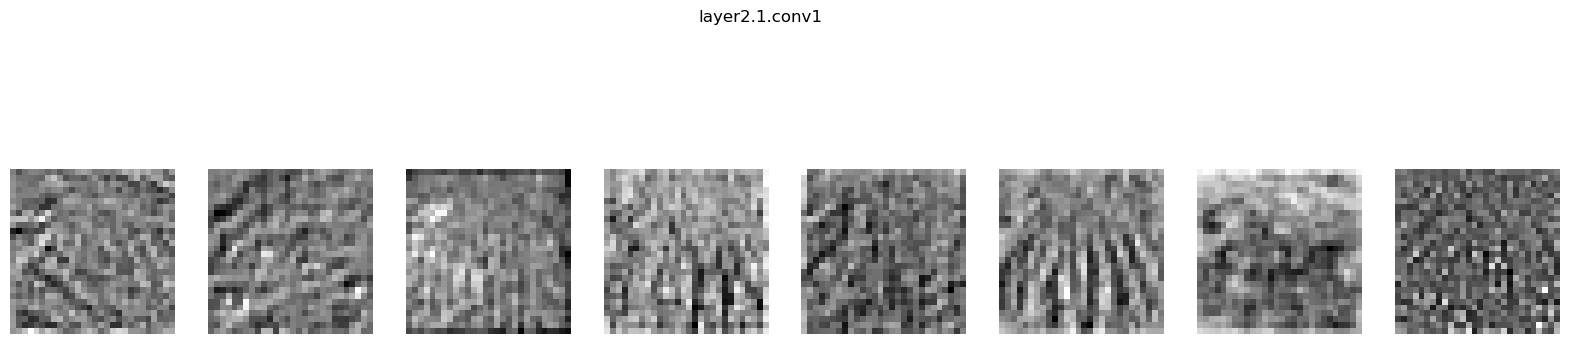

layer2.1.bn1: torch.Size([1, 128, 28, 28])


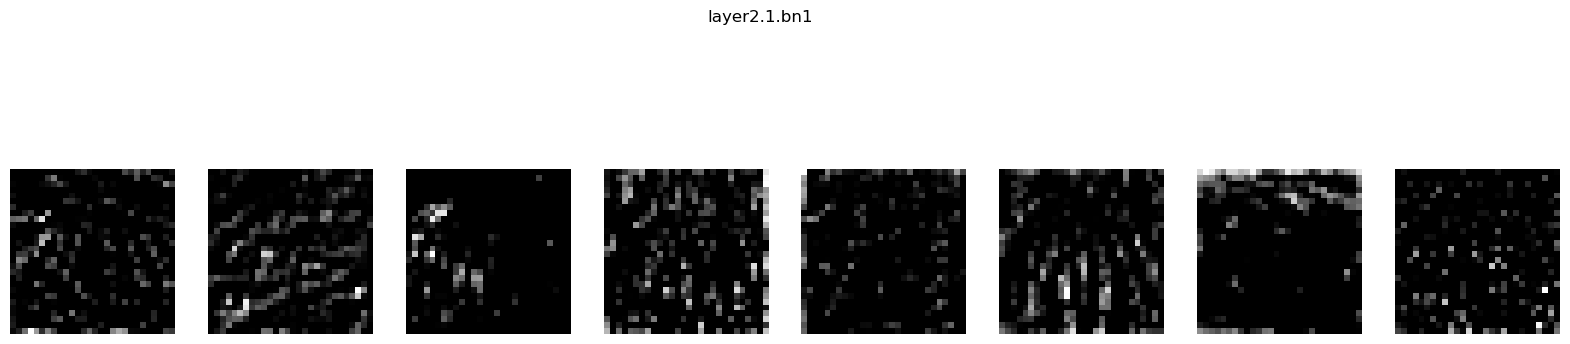

layer2.1.relu: torch.Size([1, 128, 28, 28])


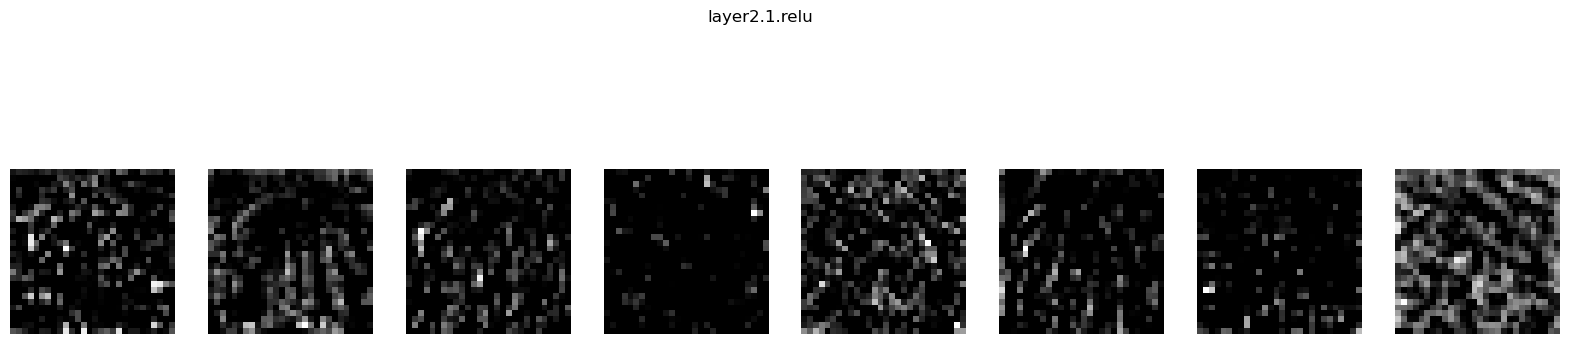

layer2.1.conv2: torch.Size([1, 128, 28, 28])


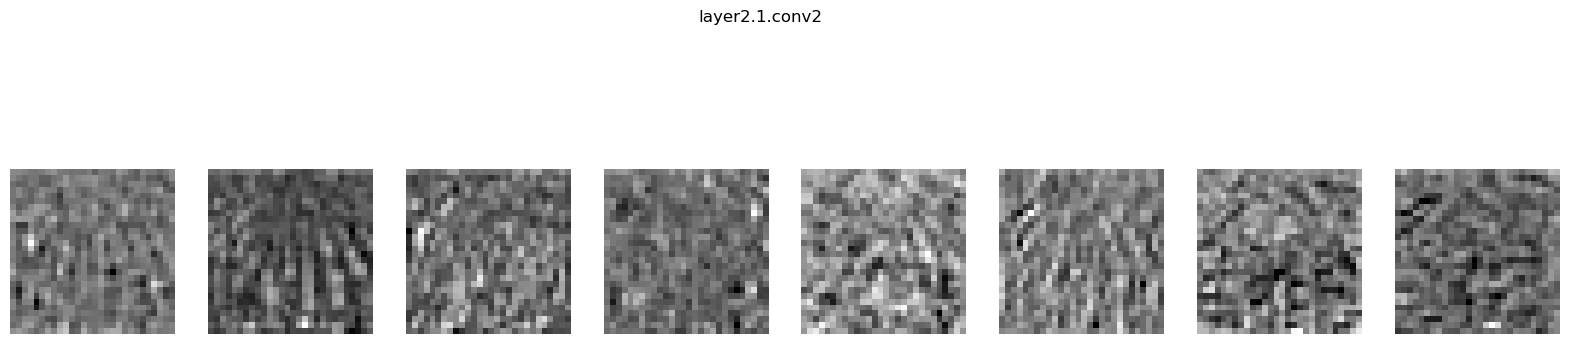

layer2.1.bn2: torch.Size([1, 128, 28, 28])


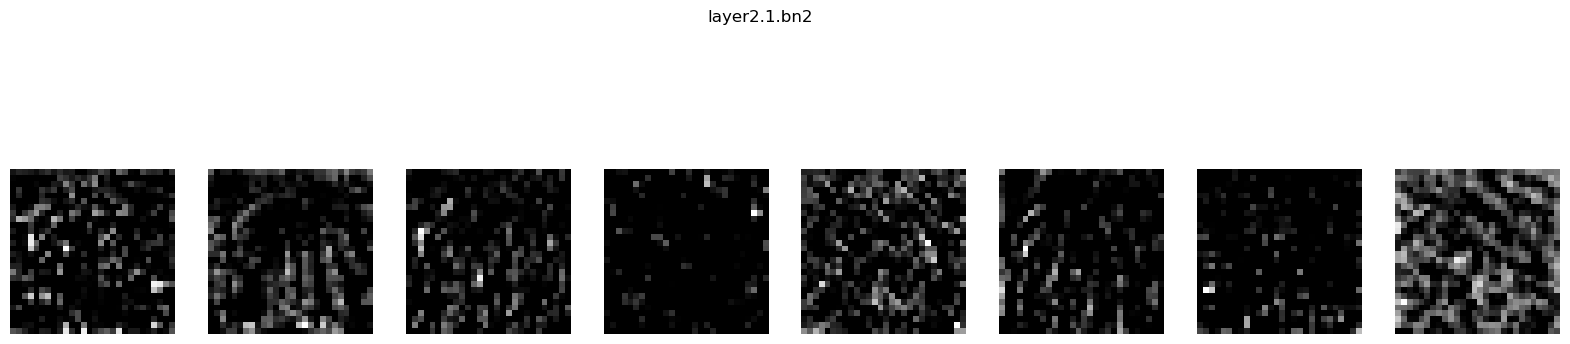

layer2.1: torch.Size([1, 128, 28, 28])


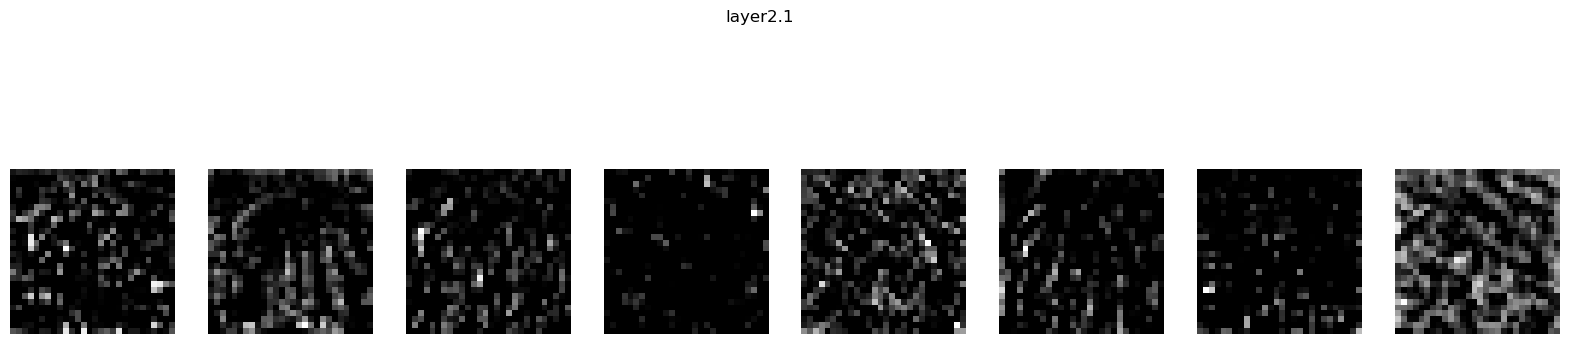

layer2: torch.Size([1, 128, 28, 28])


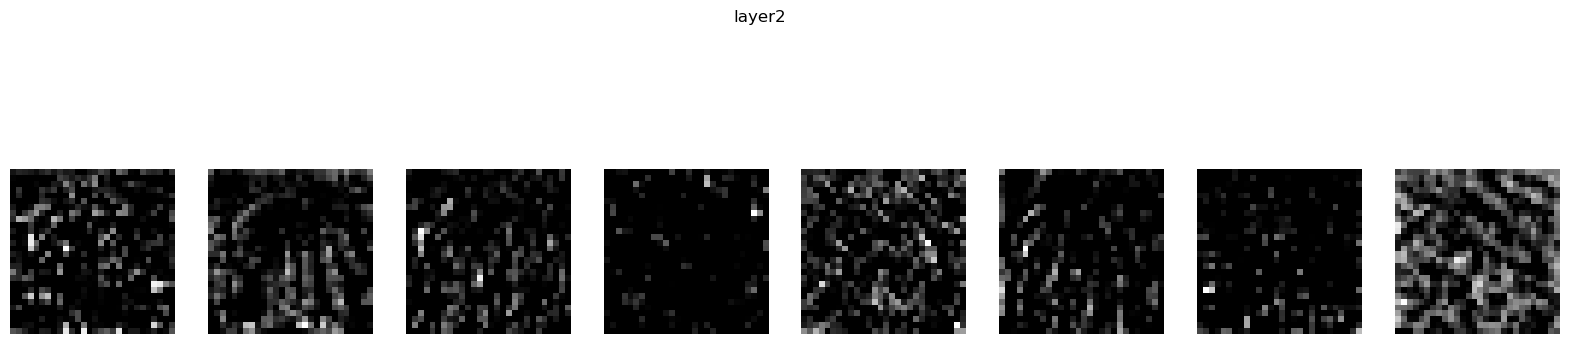

layer3.0.conv1: torch.Size([1, 256, 14, 14])


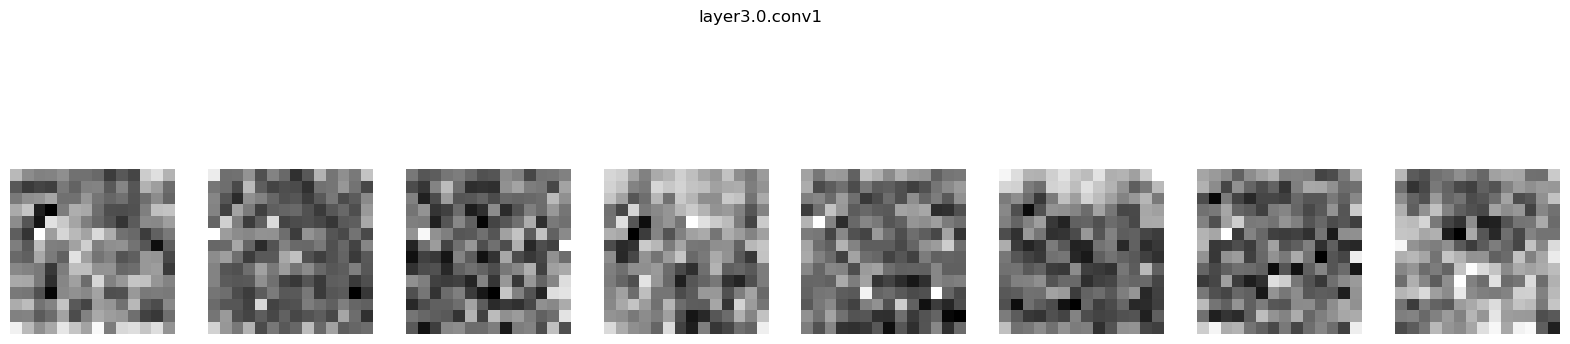

layer3.0.bn1: torch.Size([1, 256, 14, 14])


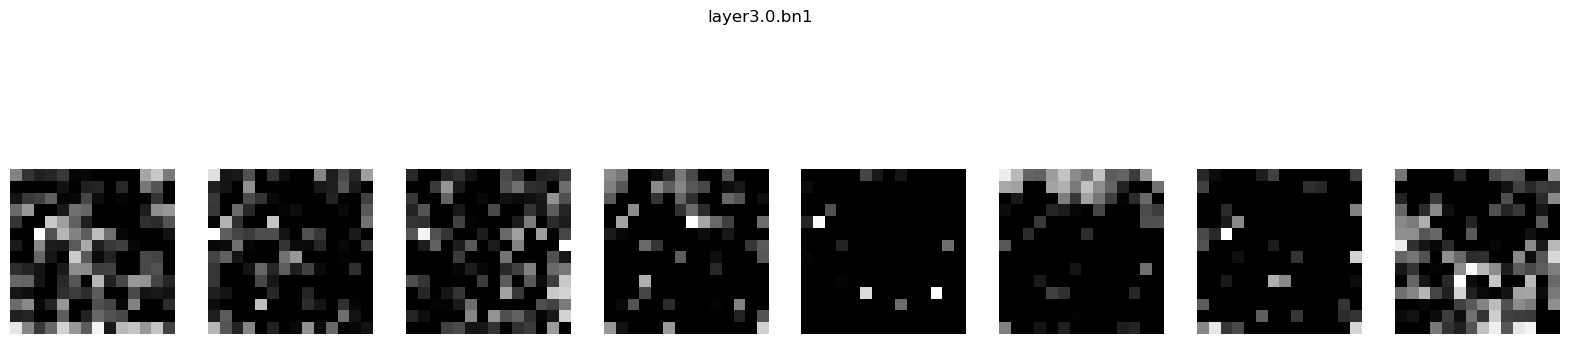

layer3.0.relu: torch.Size([1, 256, 14, 14])


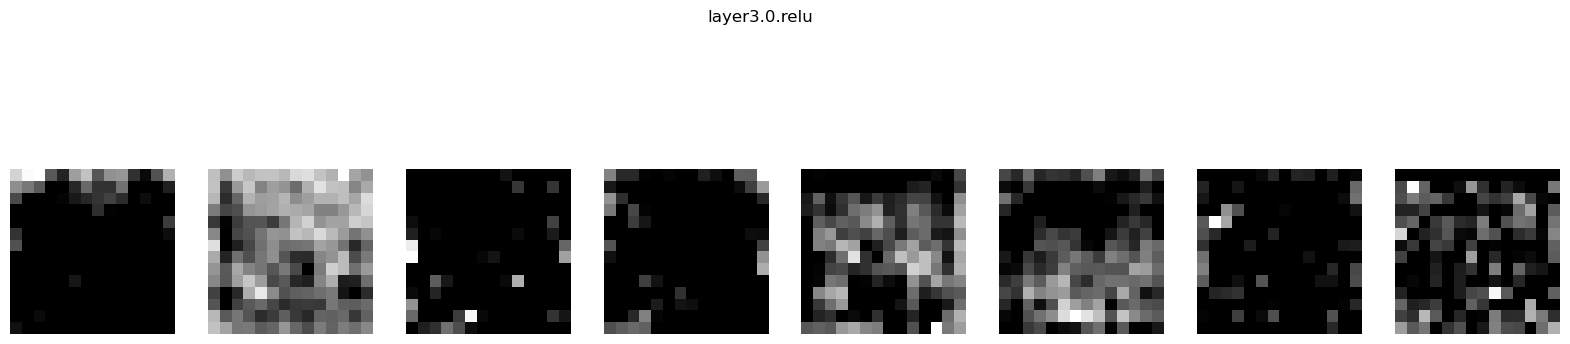

layer3.0.conv2: torch.Size([1, 256, 14, 14])


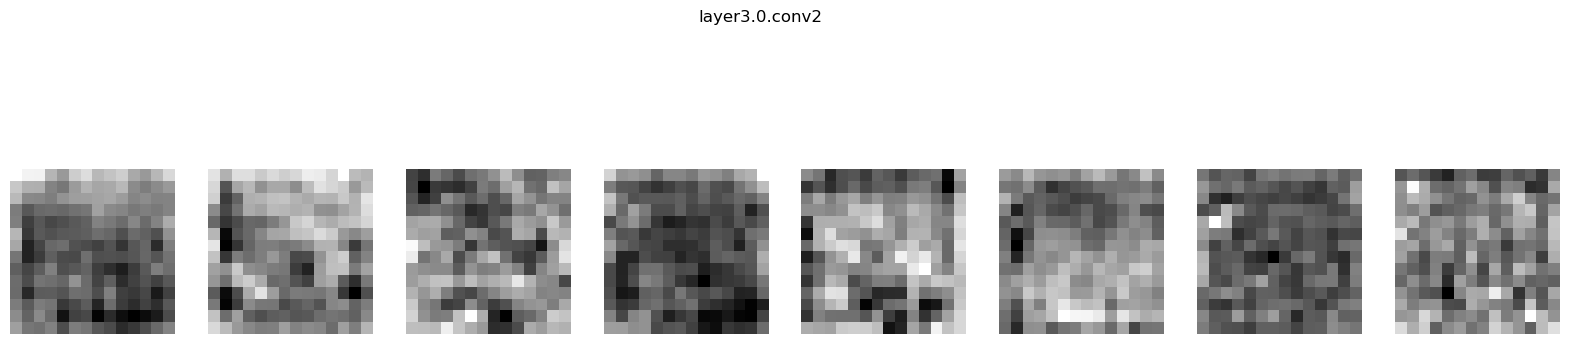

layer3.0.bn2: torch.Size([1, 256, 14, 14])


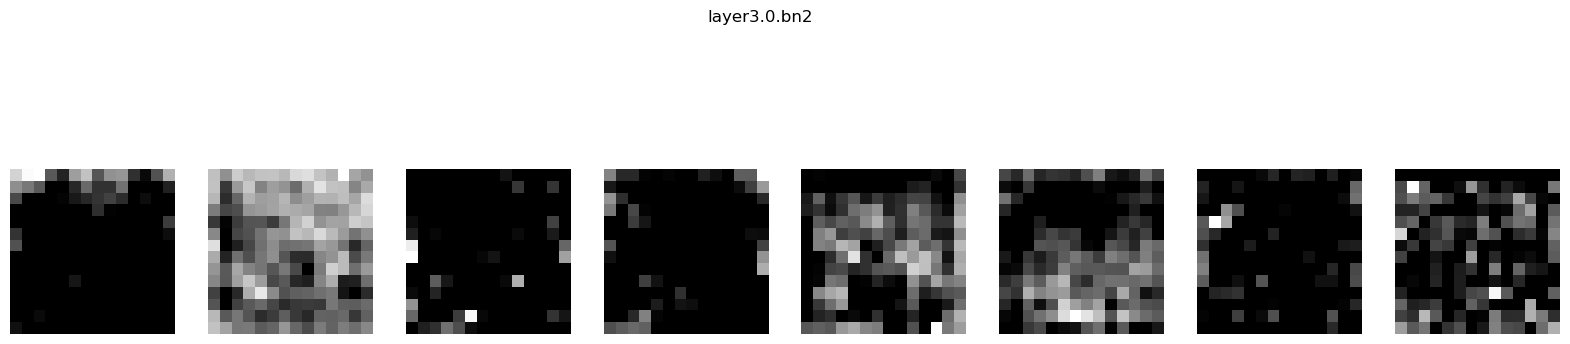

layer3.0.downsample.0: torch.Size([1, 256, 14, 14])


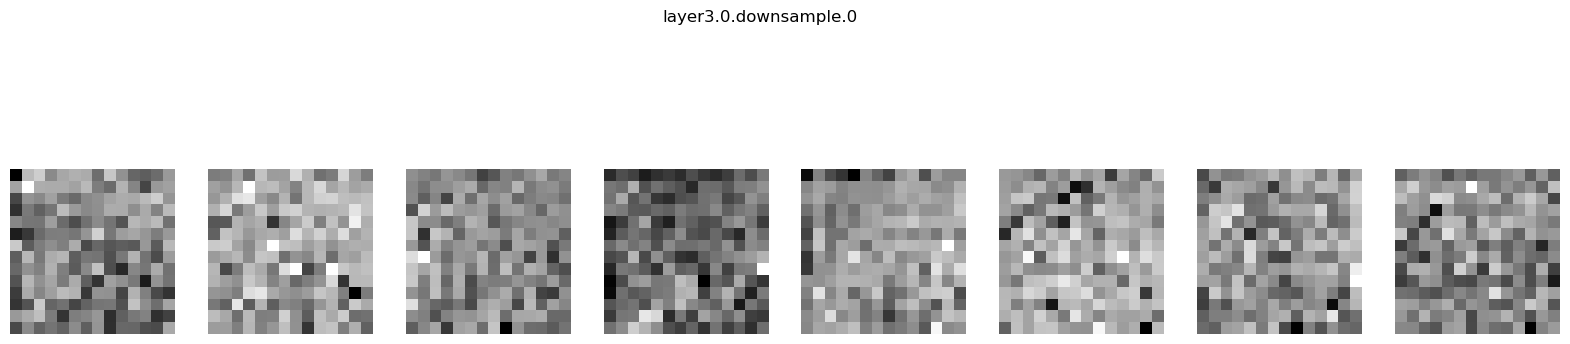

layer3.0.downsample.1: torch.Size([1, 256, 14, 14])


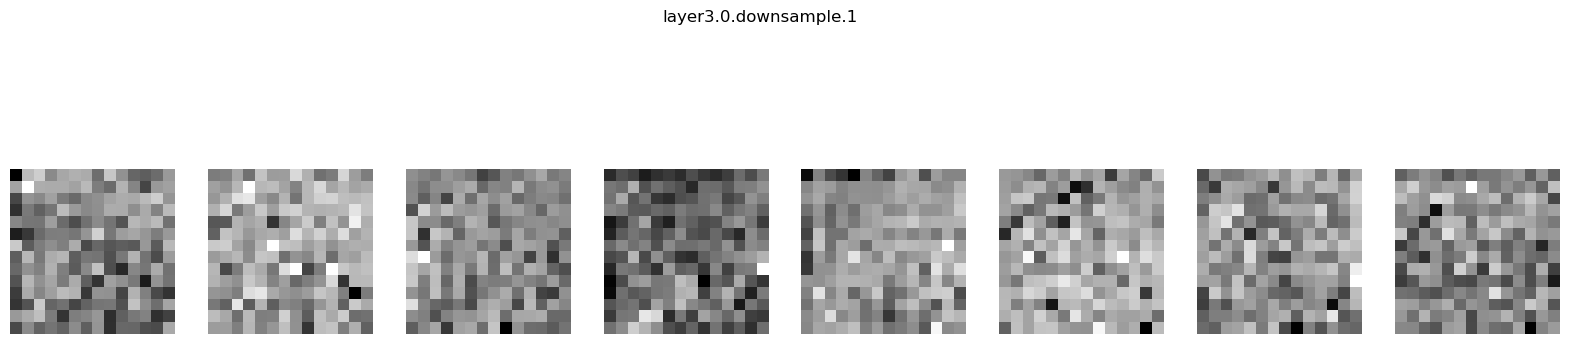

layer3.0.downsample: torch.Size([1, 256, 14, 14])


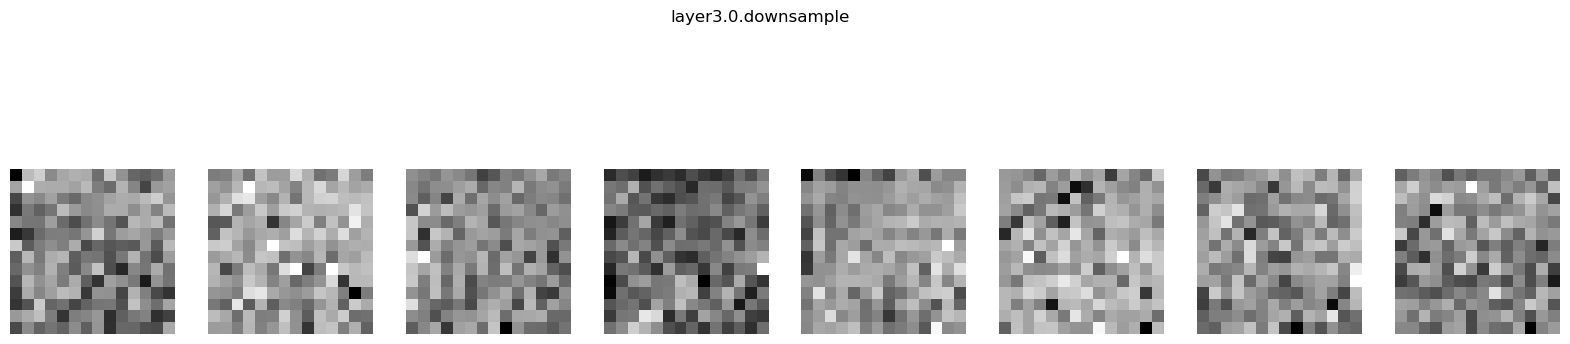

layer3.0: torch.Size([1, 256, 14, 14])


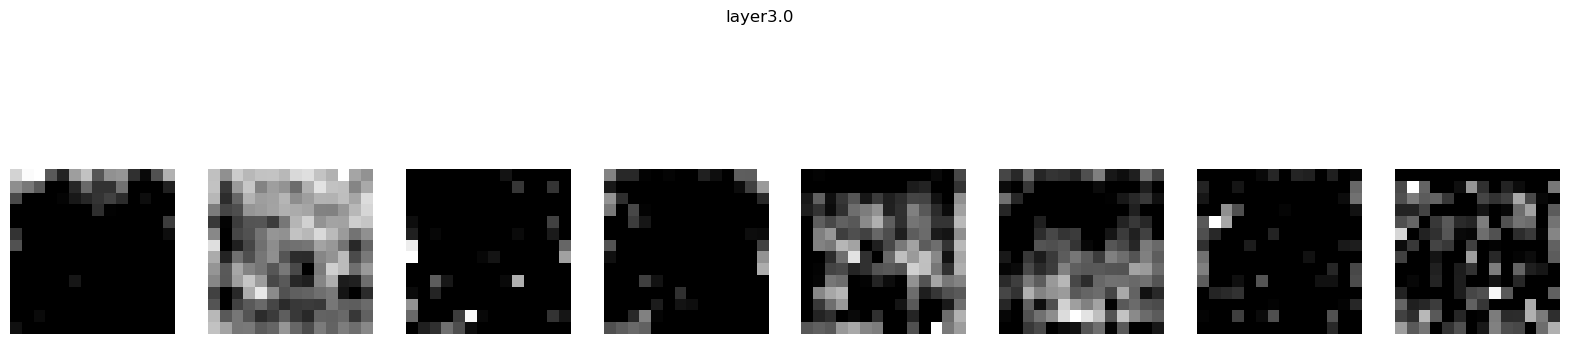

layer3.1.conv1: torch.Size([1, 256, 14, 14])


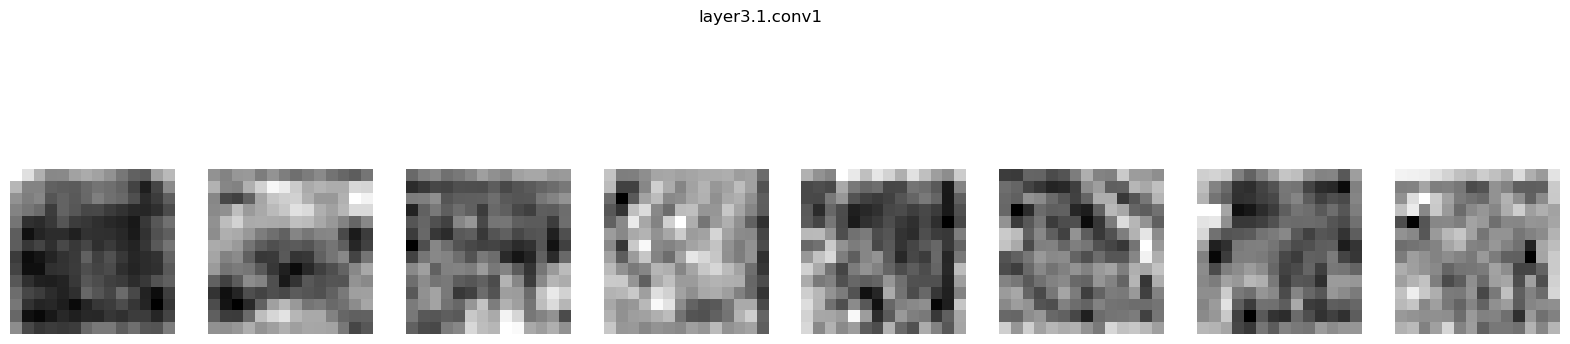

layer3.1.bn1: torch.Size([1, 256, 14, 14])


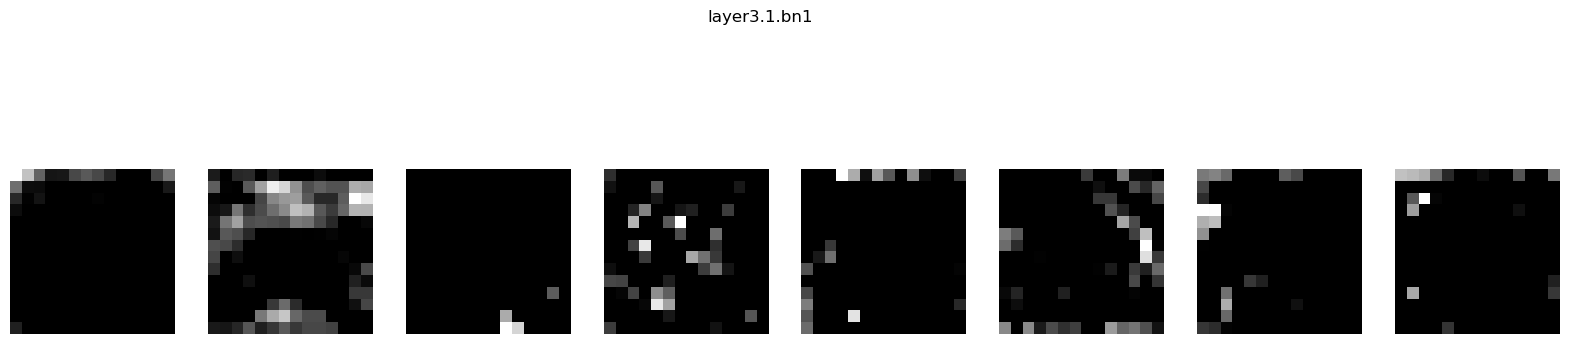

layer3.1.relu: torch.Size([1, 256, 14, 14])


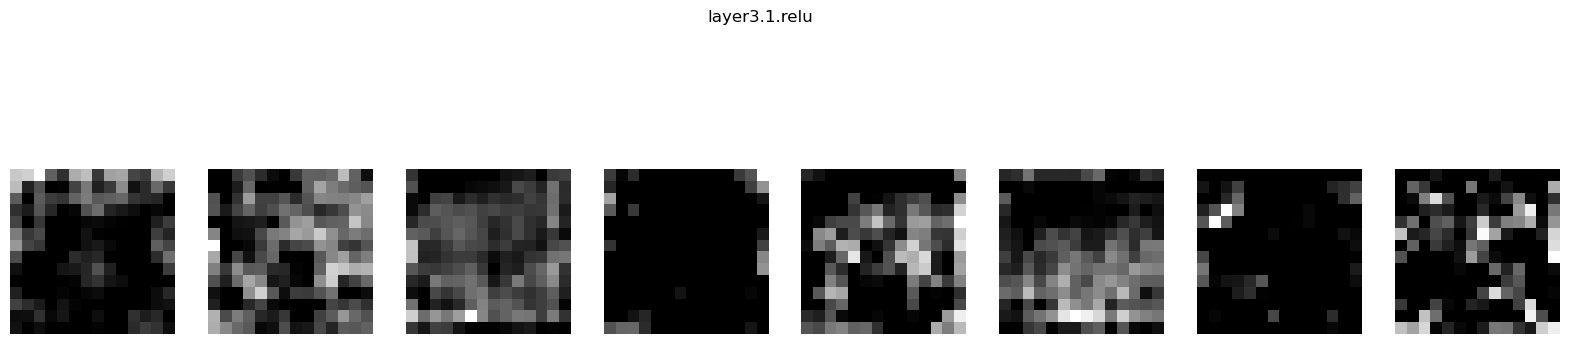

layer3.1.conv2: torch.Size([1, 256, 14, 14])


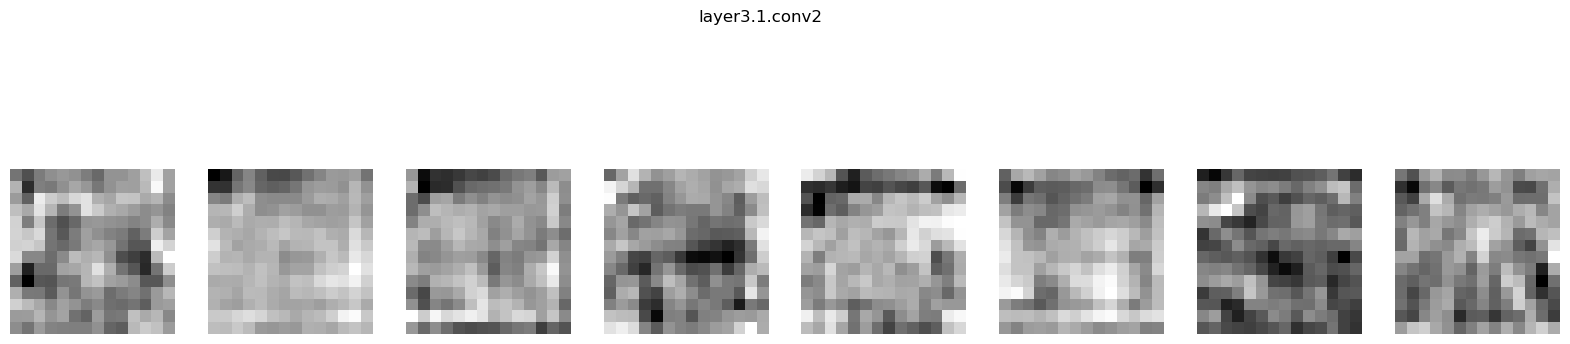

layer3.1.bn2: torch.Size([1, 256, 14, 14])


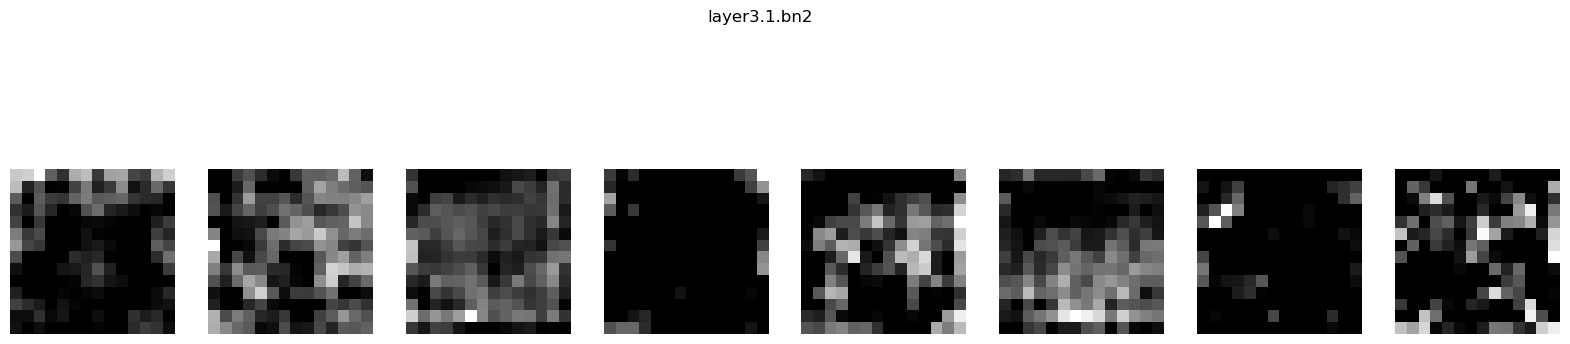

layer3.1: torch.Size([1, 256, 14, 14])


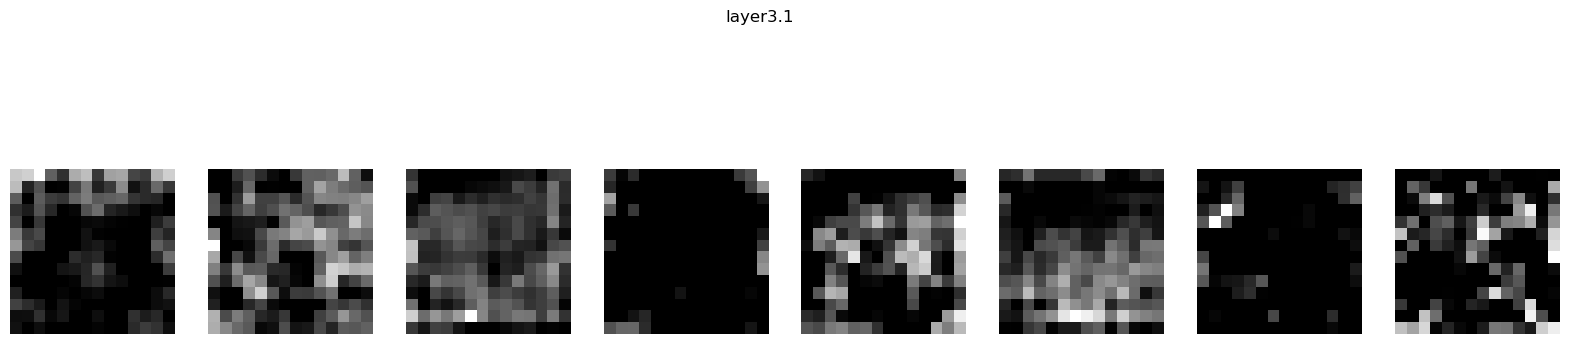

layer3: torch.Size([1, 256, 14, 14])


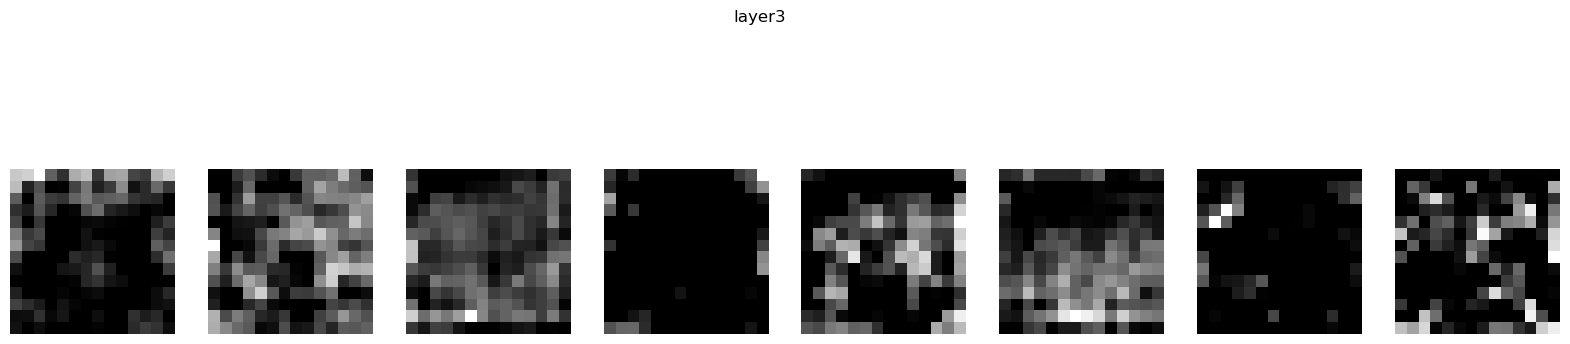

layer4.0.conv1: torch.Size([1, 512, 7, 7])


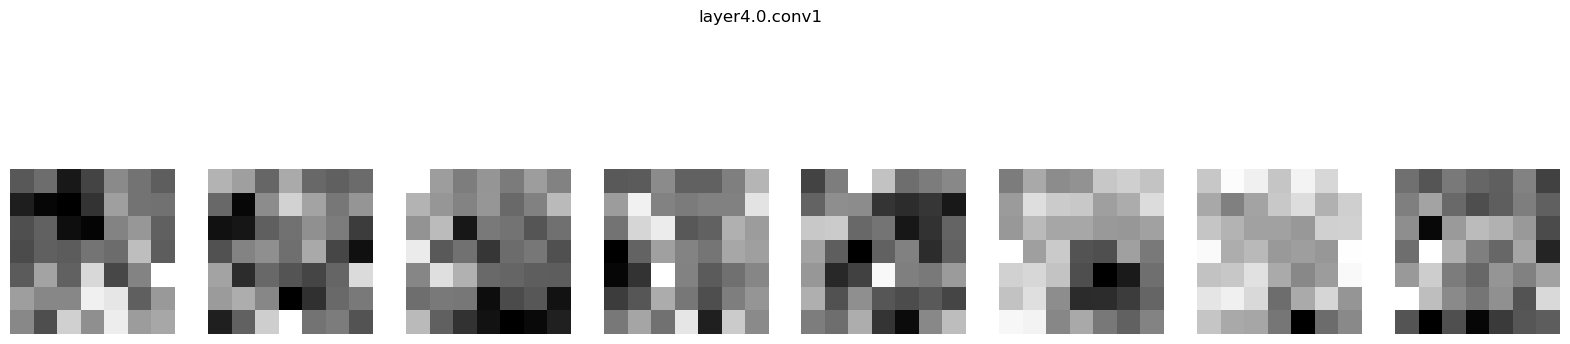

layer4.0.bn1: torch.Size([1, 512, 7, 7])


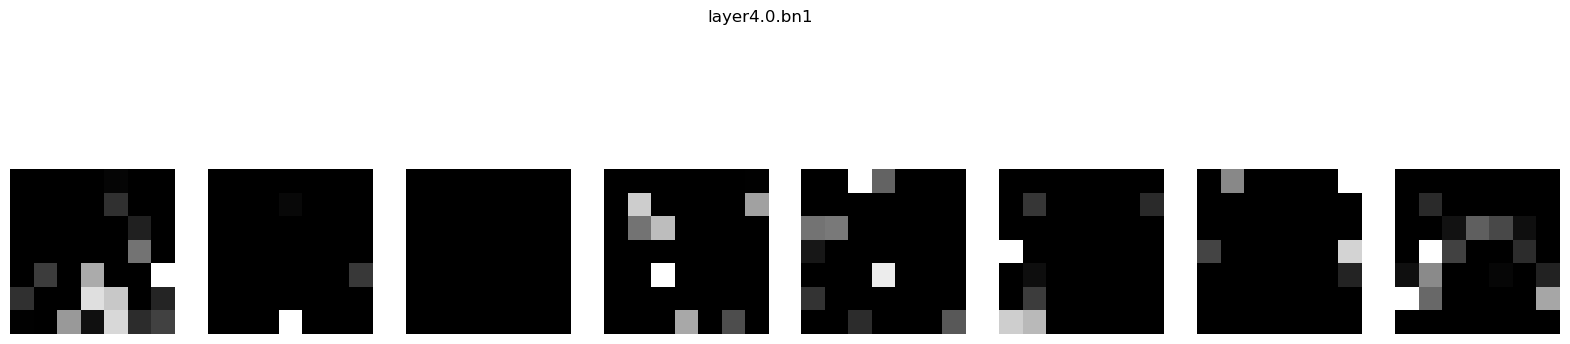

layer4.0.relu: torch.Size([1, 512, 7, 7])


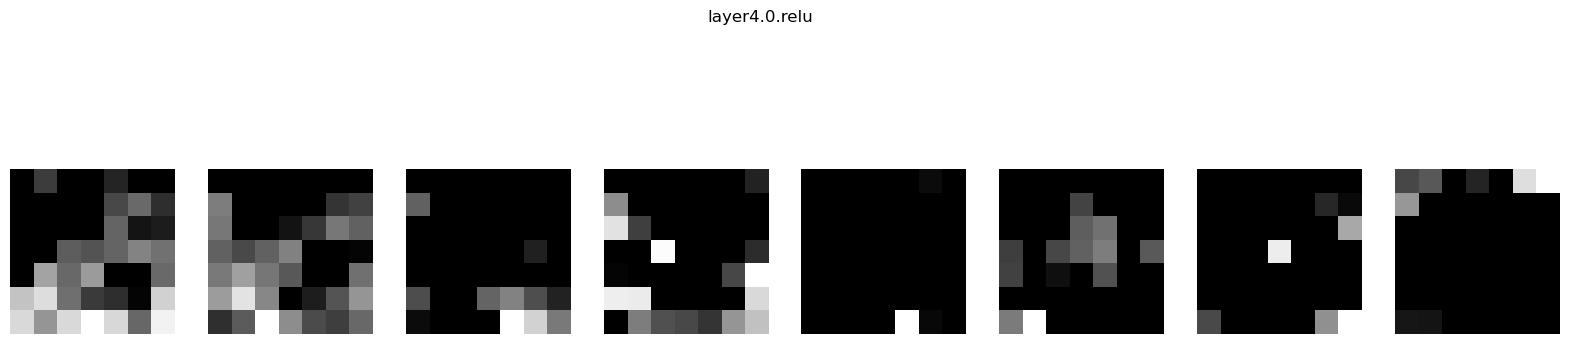

layer4.0.conv2: torch.Size([1, 512, 7, 7])


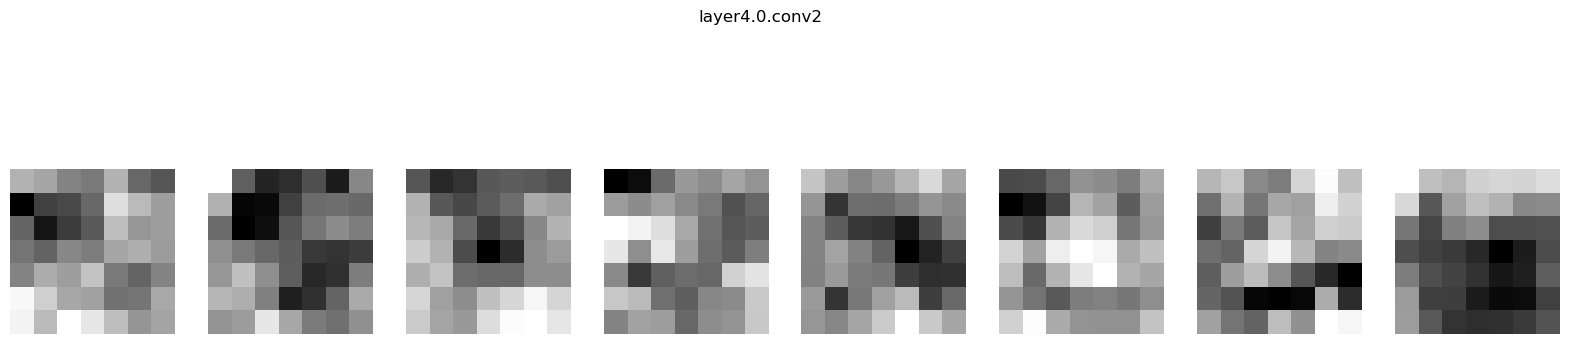

layer4.0.bn2: torch.Size([1, 512, 7, 7])


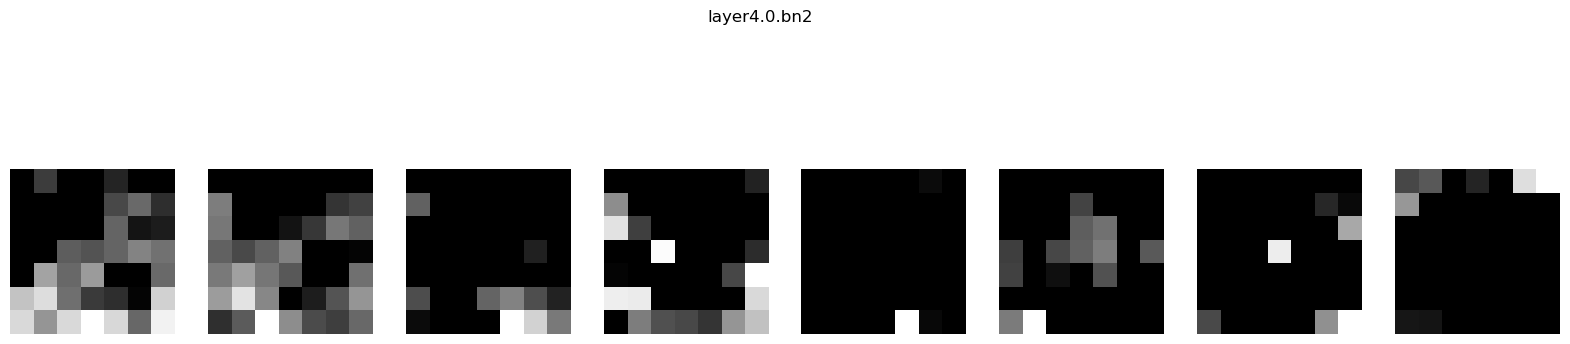

layer4.0.downsample.0: torch.Size([1, 512, 7, 7])


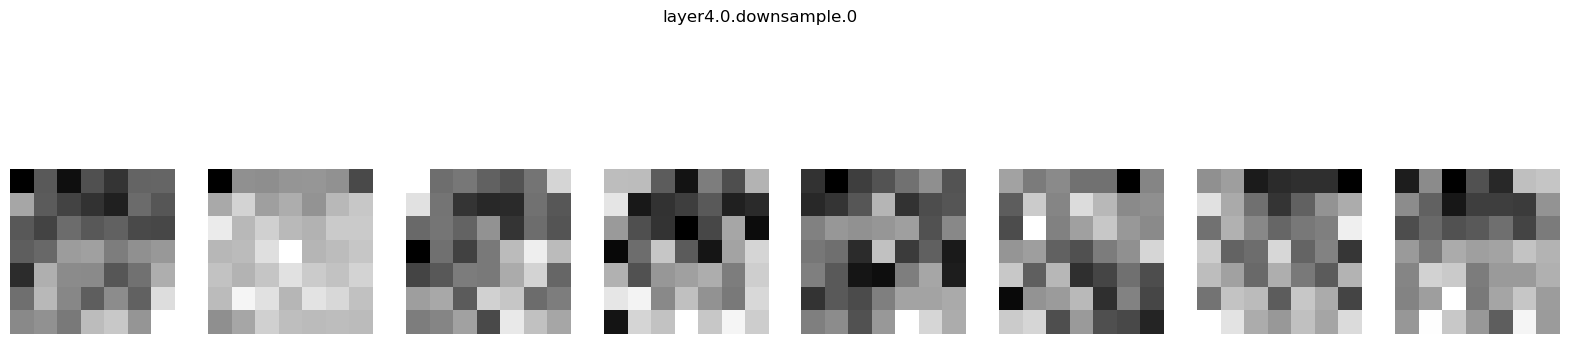

layer4.0.downsample.1: torch.Size([1, 512, 7, 7])


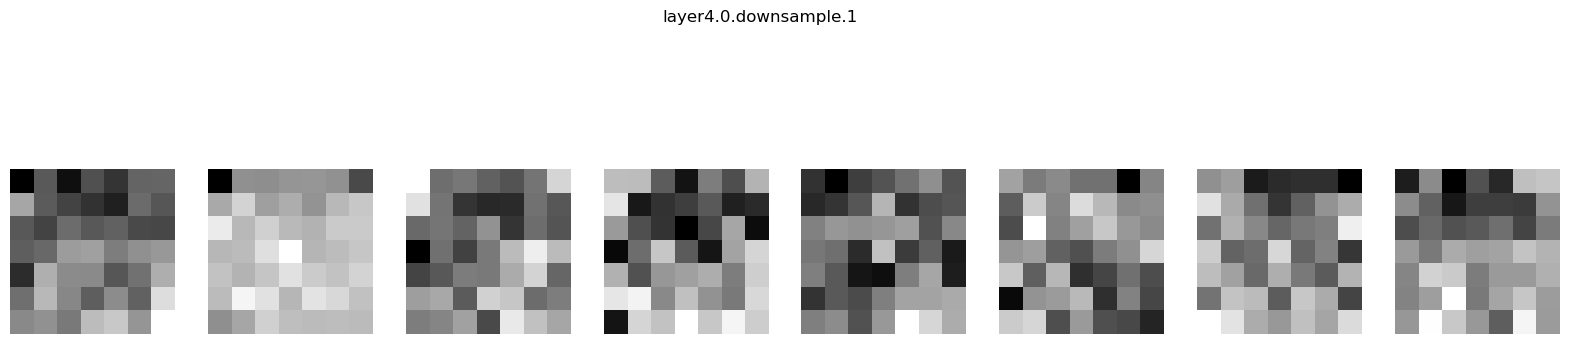

layer4.0.downsample: torch.Size([1, 512, 7, 7])


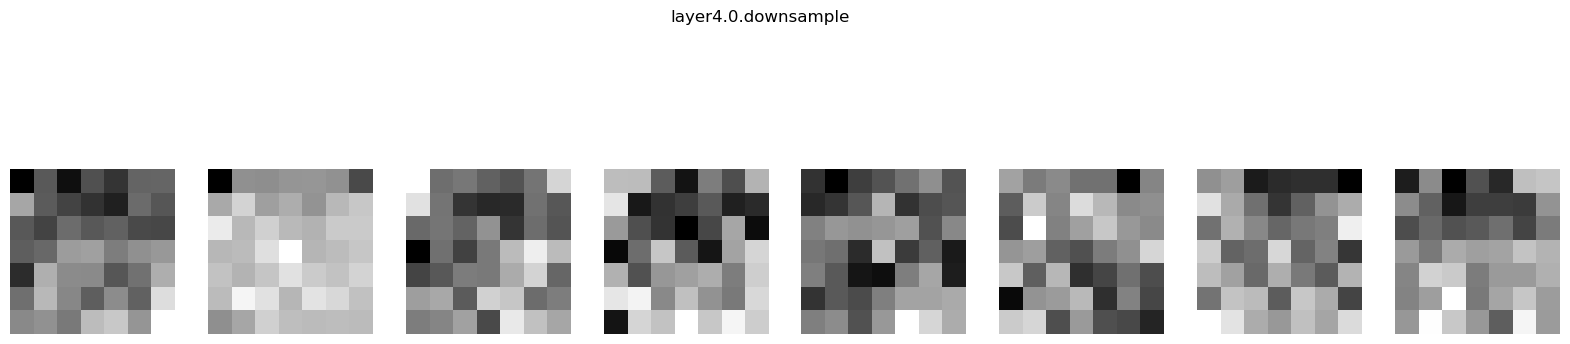

layer4.0: torch.Size([1, 512, 7, 7])


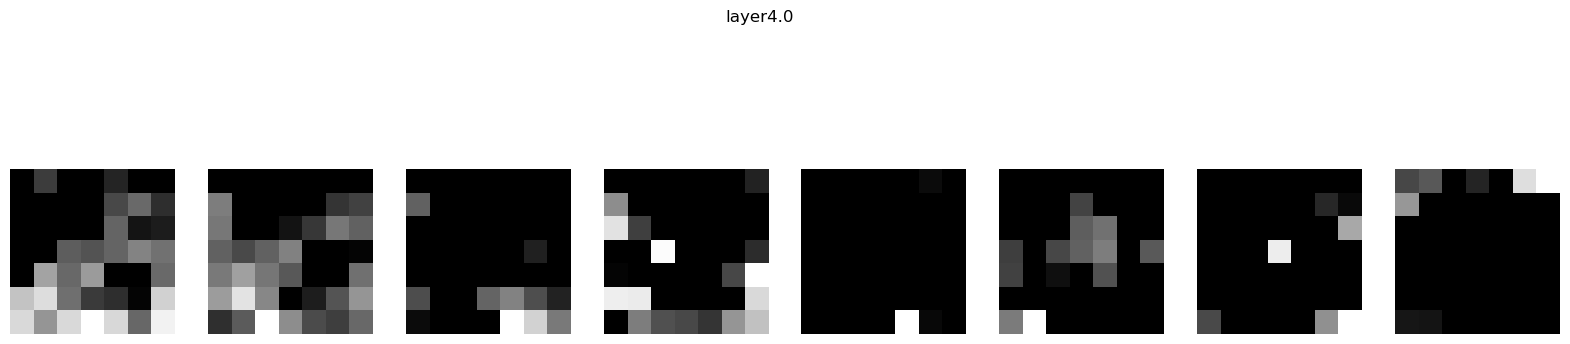

layer4.1.conv1: torch.Size([1, 512, 7, 7])


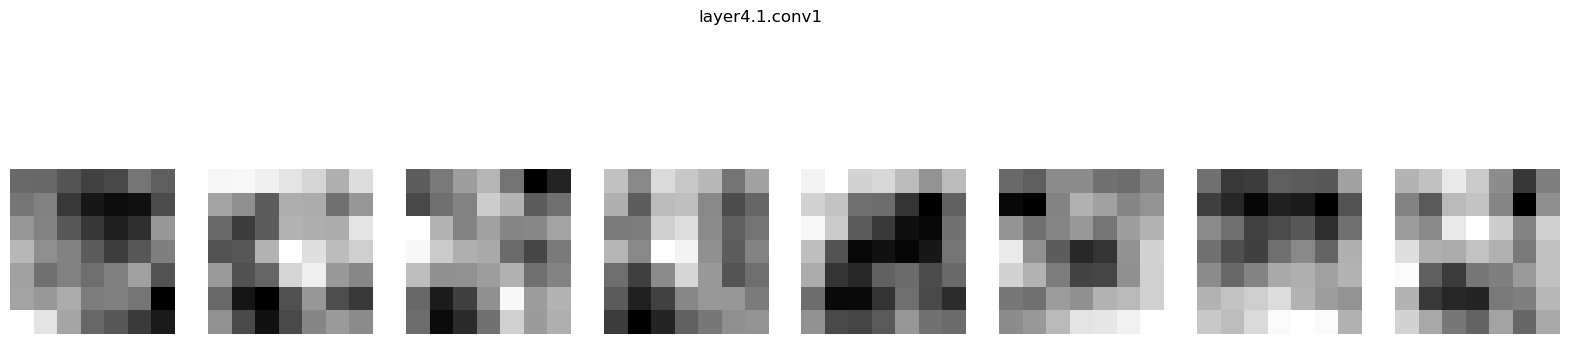

layer4.1.bn1: torch.Size([1, 512, 7, 7])


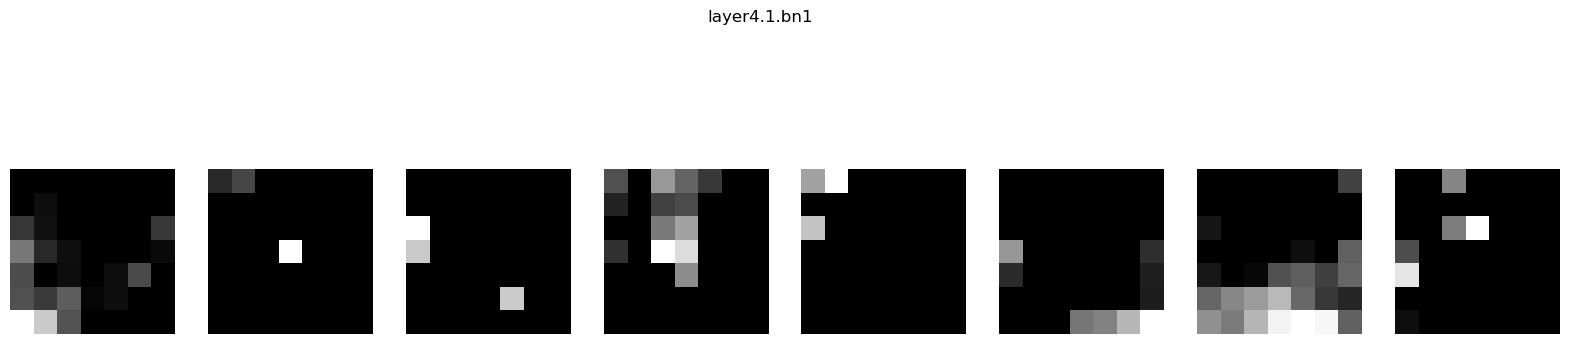

layer4.1.relu: torch.Size([1, 512, 7, 7])


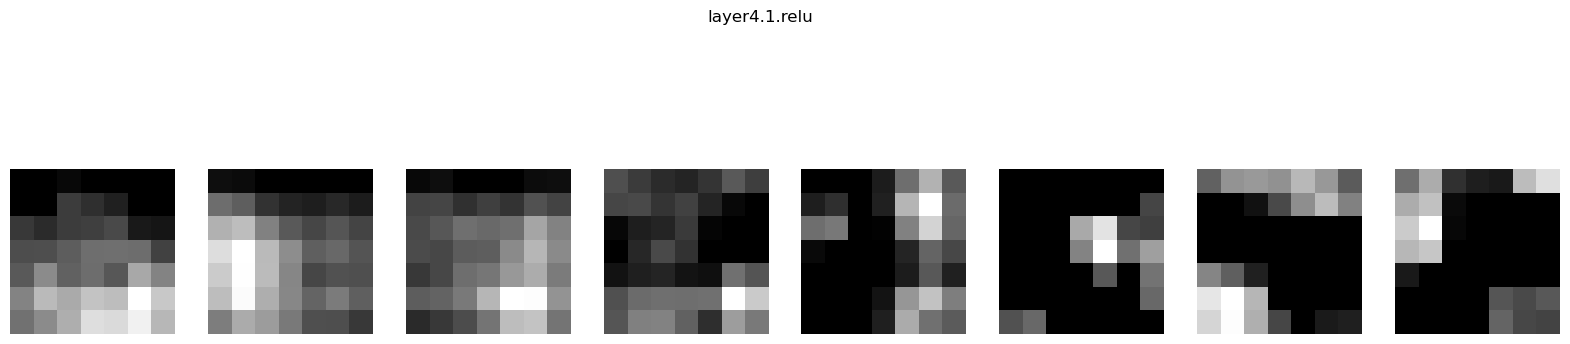

layer4.1.conv2: torch.Size([1, 512, 7, 7])


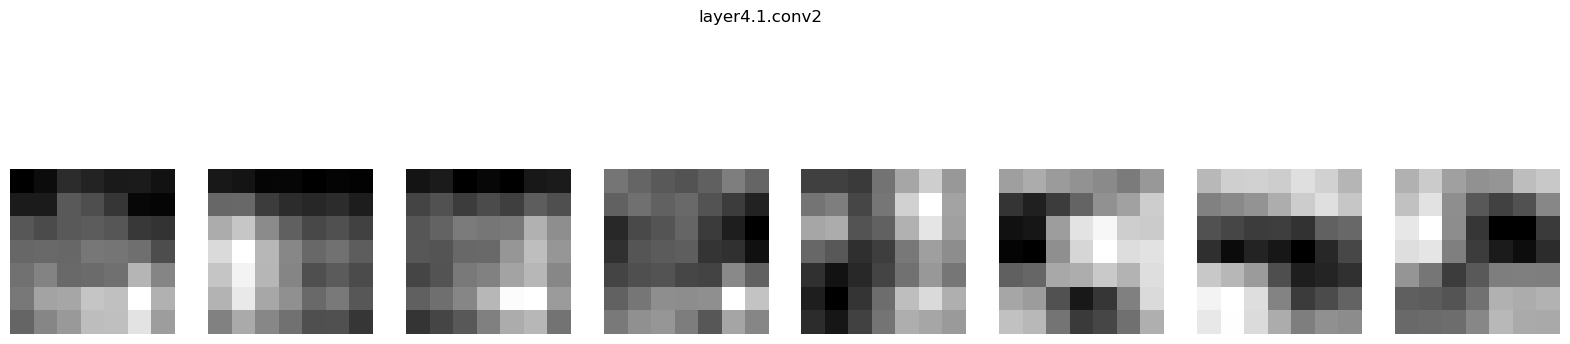

layer4.1.bn2: torch.Size([1, 512, 7, 7])


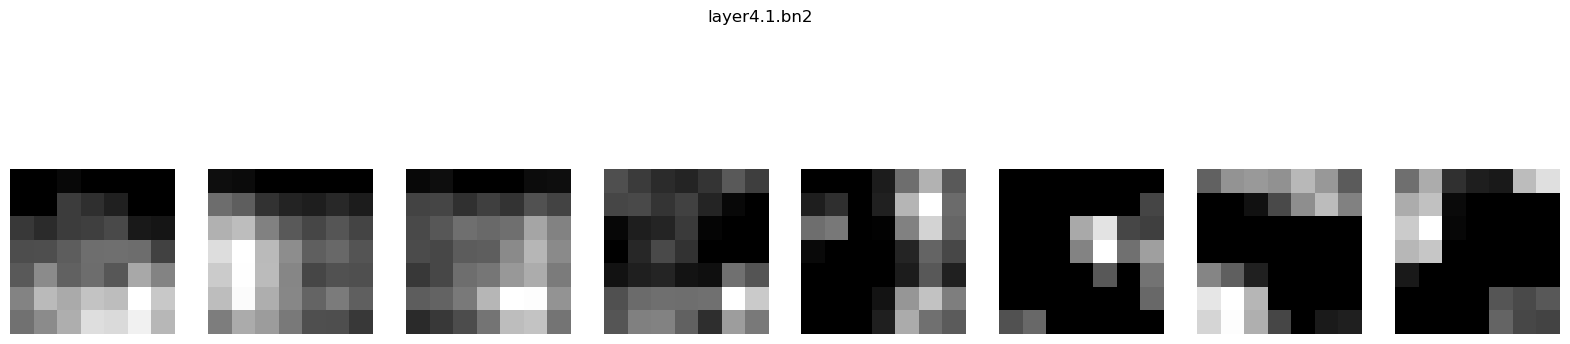

layer4.1: torch.Size([1, 512, 7, 7])


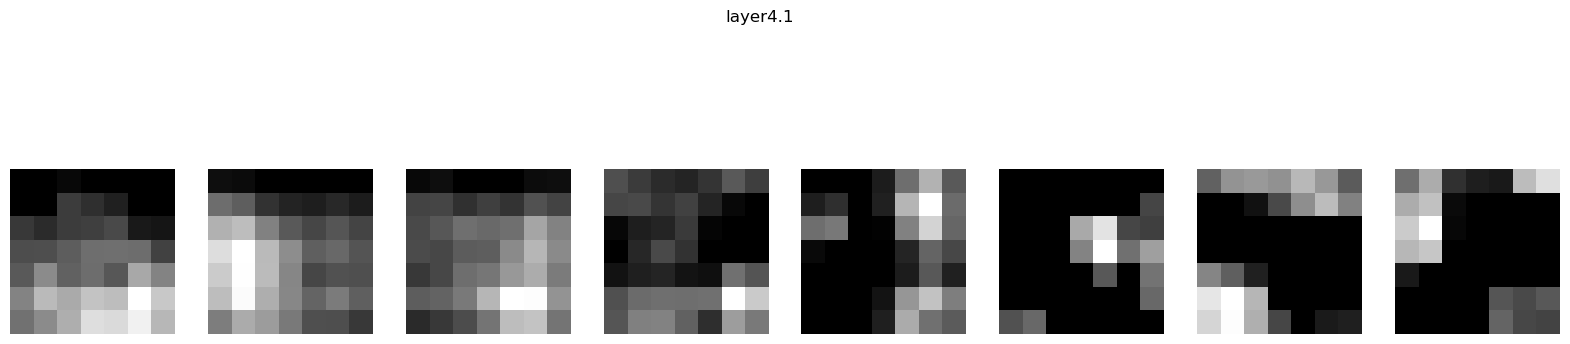

layer4: torch.Size([1, 512, 7, 7])


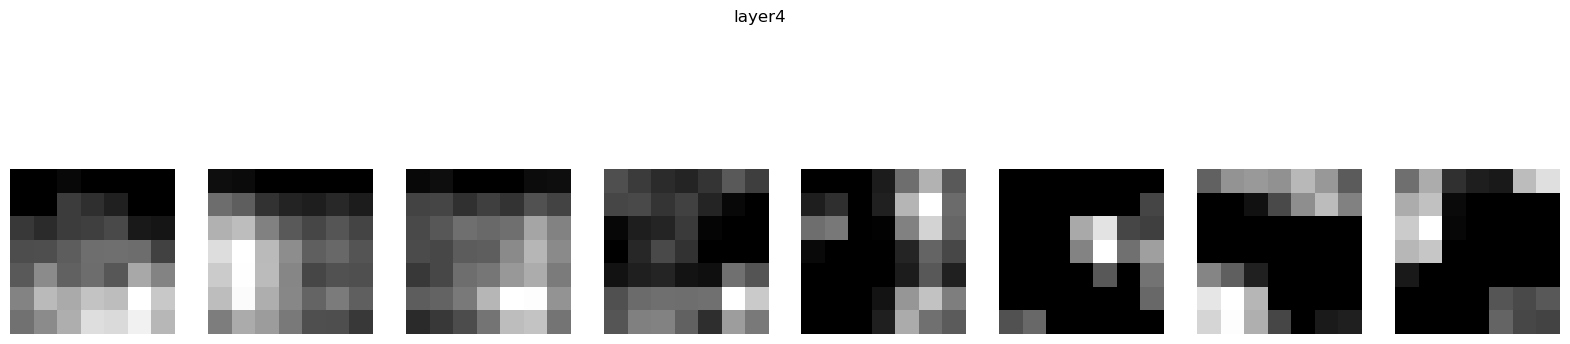

avgpool: torch.Size([1, 512, 1, 1])


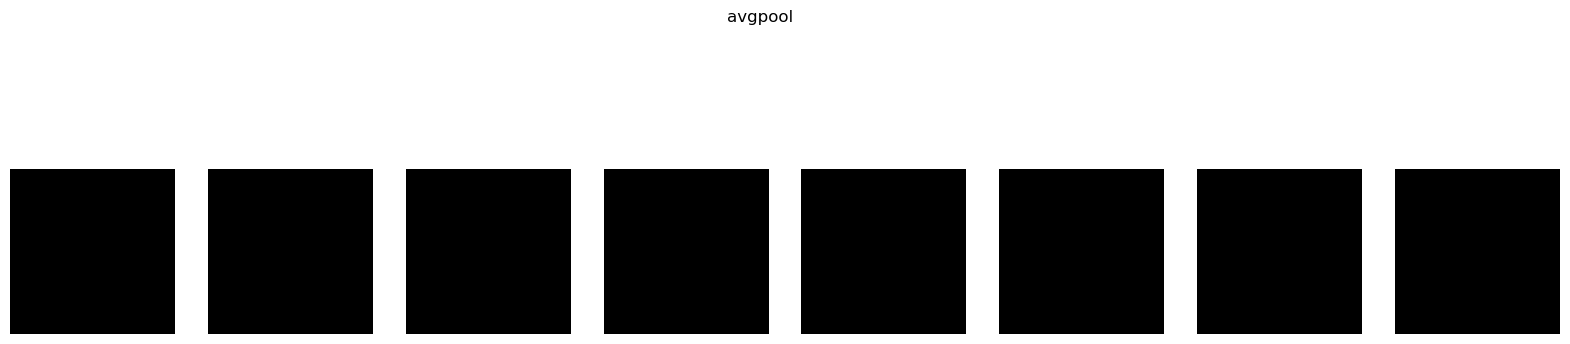

fc: torch.Size([1, 1000])
: torch.Size([1, 1000])


In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Load model
# -------------------------------------------------------------------
torch.hub.set_dir('D:/ML/Models/')
model = models.resnet18(pretrained=True)
model.eval()

# -------------------------------------------------------------------
# 2. Register hooks for all layers
# -------------------------------------------------------------------
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))

# -------------------------------------------------------------------
# 3. Preprocess input image
# -------------------------------------------------------------------
img = Image.open(r"C:\Users\PARAMPREET\Downloads\sample.jpg").convert("RGB")
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
x = transform(img).unsqueeze(0)  # (1, 3, 224, 224)

# -------------------------------------------------------------------
# 4. Forward pass
# -------------------------------------------------------------------
_ = model(x)

# -------------------------------------------------------------------
# 5. Visualize activations
# -------------------------------------------------------------------
for name, activation in activations.items():
    print(f"{name}: {activation.shape}")

    # Only visualize 4D feature maps (batch, channels, H, W)
    if activation.dim() == 4:
        num_channels = activation.shape[1]
        num_show = min(8, num_channels)  # show up to 8 channels

        fig, axs = plt.subplots(1, num_show, figsize=(20, 5))
        for i in range(num_show):
            axs[i].imshow(activation[0, i].cpu(), cmap="gray")
            axs[i].axis("off")
        fig.suptitle(name)
        plt.show()
